# **Bibliotecas e Funções**

In [ ]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Preparação dos Dados**

In [ ]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

## **Colo de Útero**

In [ ]:
# Leitura dos dados de colo de útero
df_colo_utero = pd.read_csv('colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


In [ ]:
df_colo_utero_ano3 = df_colo_utero[~((df_colo_utero.obito_geral == 0) & (df_colo_utero.sobrevida_ano3 == 0))].reset_index(drop=True)
df_colo_utero_ano3.shape

(20980, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colo_utero_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (15735, 25), X_test = (5245, 25)
y_train = (15735,), y_test = (5245,)


In [ ]:
# Dataset de treinamento de Colo de Útero
colo_utero_treino = pd.DataFrame(X_train, columns=feat_cols)
colo_utero_treino['TOPOGRUP'] = 0
colo_utero_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Colo de Útero
colo_utero_teste = pd.DataFrame(X_test, columns=feat_cols)
colo_utero_teste['TOPOGRUP'] = 0
colo_utero_teste['sobrevida_3anos'] = y_test.values

colo_utero_treino.shape, colo_utero_teste.shape

((15735, 27), (5245, 27))

## **Colorretal**

In [ ]:
# Leitura dos dados de colorretal
df_colo = pd.read_csv('colorretal.csv')
print(df_colo.shape)
df_colo.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


In [ ]:
df_colo_ano3 = df_colo[~((df_colo.obito_geral == 0) & (df_colo.sobrevida_ano3 == 0))].reset_index(drop=True)
df_colo_ano3.shape

(54349, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colo_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (40761, 25), X_test = (13588, 25)
y_train = (40761,), y_test = (13588,)


In [ ]:
# Dataset de treinamento de Colorretal
colo_treino = pd.DataFrame(X_train, columns=feat_cols)
colo_treino['TOPOGRUP'] = 1
colo_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Colorretal
colo_teste = pd.DataFrame(X_test, columns=feat_cols)
colo_teste['TOPOGRUP'] = 1
colo_teste['sobrevida_3anos'] = y_test.values

colo_treino.shape, colo_teste.shape

((40761, 27), (13588, 27))

## **Mama**

In [ ]:
# Leitura dos dados de mama
df_mama = pd.read_csv('mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


In [ ]:
df_mama_ano3 = df_mama[~((df_mama.obito_geral == 0) & (df_mama.sobrevida_ano3 == 0))].reset_index(drop=True)
df_mama_ano3.shape

(100925, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_mama_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (75693, 25), X_test = (25232, 25)
y_train = (75693,), y_test = (25232,)


In [ ]:
# Dataset de treinamento de Mama
mama_treino = pd.DataFrame(X_train, columns=feat_cols)
mama_treino['TOPOGRUP'] = 2
mama_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Mama
mama_teste = pd.DataFrame(X_test, columns=feat_cols)
mama_teste['TOPOGRUP'] = 2
mama_teste['sobrevida_3anos'] = y_test.values

mama_treino.shape, mama_teste.shape

((75693, 27), (25232, 27))

## **Pele**

In [ ]:
# Leitura dos dados de pele
df_pele = pd.read_csv('pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


In [ ]:
df_pele.dropna(inplace=True)
df_pele.shape

(183163, 32)

In [ ]:
df_pele_ano3 = df_pele[~((df_pele.obito_geral == 0) & (df_pele.sobrevida_ano3 == 0))].reset_index(drop=True)
df_pele_ano3.shape

(98308, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pele_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (73731, 25), X_test = (24577, 25)
y_train = (73731,), y_test = (24577,)


In [ ]:
# Dataset de treinamento de Pele
pele_treino = pd.DataFrame(X_train, columns=feat_cols)
pele_treino['TOPOGRUP'] = 3
pele_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Pele
pele_teste = pd.DataFrame(X_test, columns=feat_cols)
pele_teste['TOPOGRUP'] = 3
pele_teste['sobrevida_3anos'] = y_test.values

pele_treino.shape, pele_teste.shape

((73731, 27), (24577, 27))

## **Próstata**

In [ ]:
# Leitura dos dados de próstata
df_prost = pd.read_csv('prostata.csv')
print(df_prost.shape)
df_prost.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


In [ ]:
df_prost_ano3 = df_prost[~((df_prost.obito_geral == 0) & (df_prost.sobrevida_ano3 == 0))].reset_index(drop=True)
df_prost_ano3.shape

(80576, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_prost_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (60432, 25), X_test = (20144, 25)
y_train = (60432,), y_test = (20144,)


In [ ]:
# Dataset de treinamento de Próstata
prost_treino = pd.DataFrame(X_train, columns=feat_cols)
prost_treino['TOPOGRUP'] = 4
prost_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Próstata
prost_teste = pd.DataFrame(X_test, columns=feat_cols)
prost_teste['TOPOGRUP'] = 4
prost_teste['sobrevida_3anos'] = y_test.values

prost_treino.shape, prost_teste.shape

((60432, 27), (20144, 27))

## **Pulmão**

In [ ]:
# Leitura dos dados de pulmão
df_pulm = pd.read_csv('pulmao.csv')
print(df_pulm.shape)
df_pulm.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


In [ ]:
df_pulm_ano3 = df_pulm[~((df_pulm.obito_geral == 0) & (df_pulm.sobrevida_ano3 == 0))].reset_index(drop=True)
df_pulm_ano3.shape

(36552, 32)

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pulm_ano3,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (27414, 25), X_test = (9138, 25)
y_train = (27414,), y_test = (9138,)


In [ ]:
# Dataset de treinamento de Pulmão
pulm_treino = pd.DataFrame(X_train, columns=feat_cols)
pulm_treino['TOPOGRUP'] = 5
pulm_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Pulmão
pulm_teste = pd.DataFrame(X_test, columns=feat_cols)
pulm_teste['TOPOGRUP'] = 5
pulm_teste['sobrevida_3anos'] = y_test.values

pulm_treino.shape, pulm_teste.shape

((27414, 27), (9138, 27))

## **DF treino e teste**

Treino

In [ ]:
from sklearn.utils import shuffle

df_incid_treino = pd.concat([colo_utero_treino, colo_treino, mama_treino, pele_treino,
                             prost_treino, pulm_treino],
                            ignore_index=True)
df_incid_treino = shuffle(df_incid_treino, random_state=seed)
df_incid_treino.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
74687,0.547966,0.078023,0.855700,1.228497,-0.898638,0.484489,-0.137075,-1.833906,1.009224,0.648443,...,-0.026978,-0.854011,-0.670762,0.745516,-0.804498,-0.977651,0.958238,-0.517314,2,1
69594,-0.402494,0.078023,1.012376,-0.774058,-0.898638,1.310062,-0.137075,0.545284,1.009224,0.648443,...,1.100277,0.069902,0.016212,-1.637938,-0.804498,-0.977651,-1.043582,1.933063,2,0
253002,-0.425396,0.000000,-0.857756,1.341668,-1.360059,-0.628732,-0.260850,-0.889682,-0.720286,3.258727,...,-0.908134,-1.038570,-1.826509,0.849660,3.262103,0.315539,-0.897949,-0.413965,4,1


In [ ]:
df_incid_treino.to_csv('incid_treino.csv', index=False, encoding='UTF-8')

Teste

In [ ]:
from sklearn.utils import shuffle

df_incid_teste = pd.concat([colo_utero_teste, colo_teste, mama_teste, pele_teste,
                            prost_teste, pulm_teste],
                           ignore_index=True)
df_incid_teste = shuffle(df_incid_teste, random_state=seed)
df_incid_teste.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
15893,-0.018334,-0.974444,0.882521,-0.739385,0.965963,-1.428986,-0.220933,0.600390,-0.571222,-1.355989,...,1.565391,-0.942713,-0.767966,0.798171,0.395082,1.157107,0.969004,-0.476098,1,0
60372,0.472874,1.092158,-0.066739,1.146140,2.891211,1.142804,-0.198609,0.314933,-0.242656,-0.156014,...,-1.665513,0.701595,0.341854,-0.195285,0.384835,-1.407477,-0.776590,-0.218579,3,0
3262,0.382714,0.000000,-1.604265,-0.919798,0.924719,0.148175,-0.260232,-0.791958,0.736748,1.070411,...,1.157419,-0.710675,0.651318,-1.784826,-1.016703,-0.602381,-0.911787,-0.465967,0,1


In [ ]:
df_incid_teste.to_csv('incid_teste.csv', index=False, encoding='UTF-8')

# **Dados**

In [ ]:
%%capture

!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino

In [ ]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(293766, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.547966,0.078023,0.855700,1.228497,-0.898638,0.484489,-0.137075,-1.833906,1.009224,0.648443,...,-0.026978,-0.854011,-0.670762,0.745516,-0.804498,-0.977651,0.958238,-0.517314,2,1
1,-0.402494,0.078023,1.012376,-0.774058,-0.898638,1.310062,-0.137075,0.545284,1.009224,0.648443,...,1.100277,0.069902,0.016212,-1.637938,-0.804498,-0.977651,-1.043582,1.933063,2,0
2,-0.425396,0.000000,-0.857756,1.341668,-1.360059,-0.628732,-0.260850,-0.889682,-0.720286,3.258727,...,-0.908134,-1.038570,-1.826509,0.849660,3.262103,0.315539,-0.897949,-0.413965,4,1


In [ ]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(97924, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.018334,-0.974444,0.882521,-0.739385,0.965963,-1.428986,-0.220933,0.600390,-0.571222,-1.355989,...,1.565391,-0.942713,-0.767966,0.798171,0.395082,1.157107,0.969004,-0.476098,1,0
1,0.472874,1.092158,-0.066739,1.146140,2.891211,1.142804,-0.198609,0.314933,-0.242656,-0.156014,...,-1.665513,0.701595,0.341854,-0.195285,0.384835,-1.407477,-0.776590,-0.218579,3,0
2,0.382714,0.000000,-1.604265,-0.919798,0.924719,0.148175,-0.260232,-0.791958,0.736748,1.070411,...,1.157419,-0.710675,0.651318,-1.784826,-1.016703,-0.602381,-0.911787,-0.465967,0,1


In [ ]:
# DFs de teste para cada tipo
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 0]
colo_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 1]
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 2]
pele_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 3]
prost_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 4]
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 5]

colo_utero_teste.shape, colo_teste.shape, mama_teste.shape, pele_teste.shape, prost_teste.shape, pulm_teste.shape

((5245, 27), (13588, 27), (25232, 27), (24577, 27), (20144, 27), (9138, 27))

# **Mais incidentes Juntos**

**Sem TOPOGRUP**

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TOPOGRUP', 'sobrevida_3anos']

# Treino
X_train = df_incid_treino.drop(columns=list_drop).copy()
y_train = df_incid_treino.sobrevida_3anos.copy()

# Teste
X_test = df_incid_teste.drop(columns=list_drop).copy()
y_test = df_incid_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((293766, 25), (293766,), (97924, 25), (97924,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

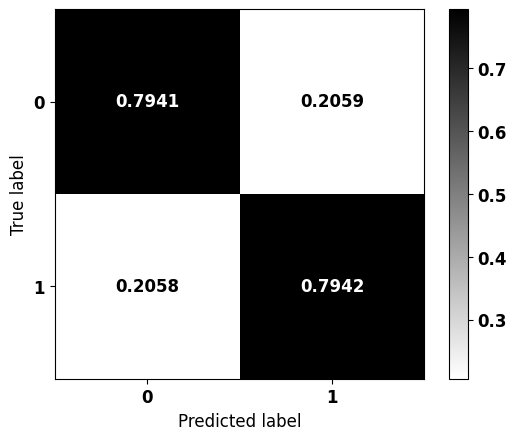


              precision    recall  f1-score   support

           0     0.6366    0.7941    0.7067     30576
           1     0.8947    0.7942    0.8415     67348

    accuracy                         0.7942     97924
   macro avg     0.7656    0.7941    0.7741     97924
weighted avg     0.8141    0.7942    0.7994     97924



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=7,
                    scale_pos_weight=0.375,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

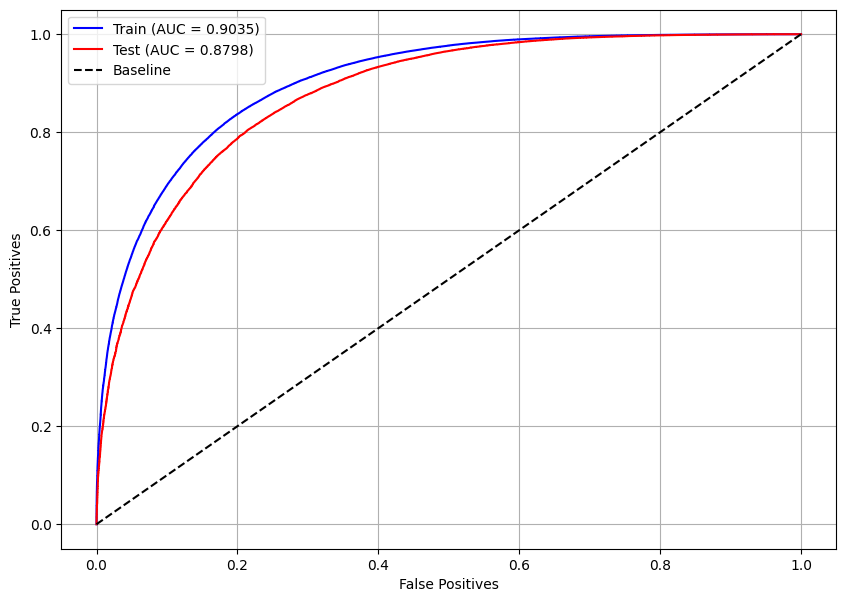

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

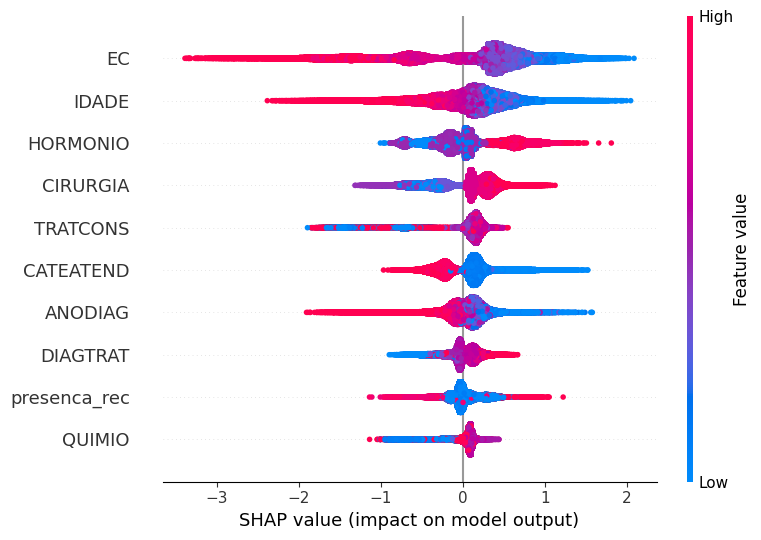

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 102,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.36, 0.4, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

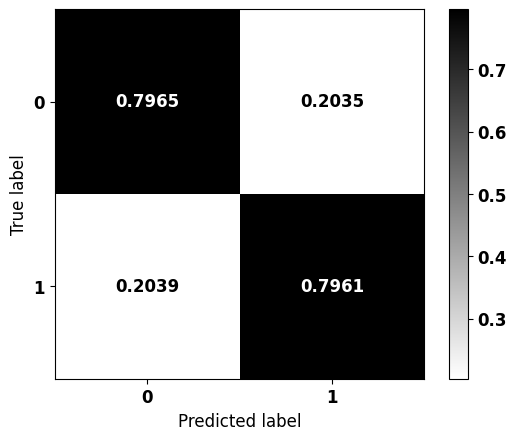


              precision    recall  f1-score   support

           0     0.6394    0.7965    0.7093     30576
           1     0.8960    0.7961    0.8431     67348

    accuracy                         0.7962     97924
   macro avg     0.7677    0.7963    0.7762     97924
weighted avg     0.8159    0.7962    0.8013     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3798

xgb_random = XGBClassifier()
xgb_random.set_params(**params)

xgb_random.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_random, X_test, y_test)

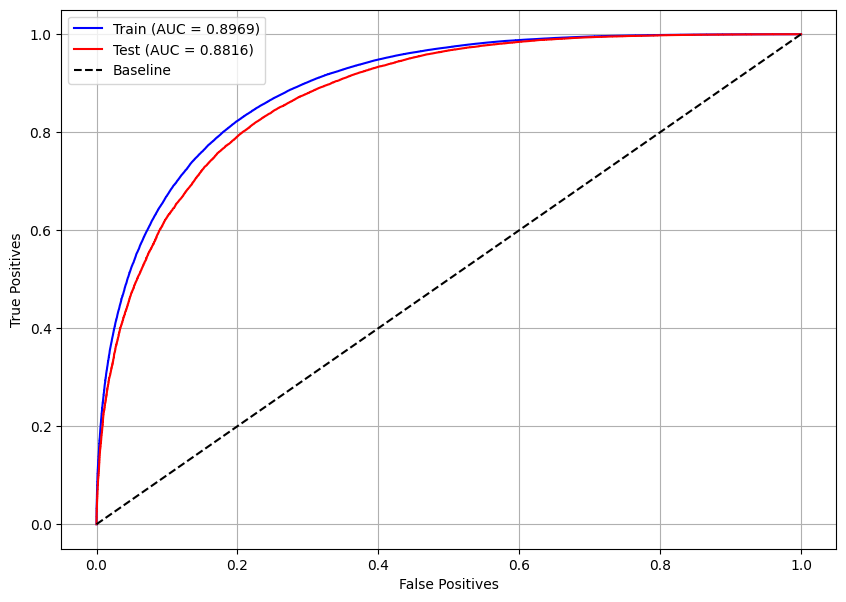

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 143,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.37, 0.39, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

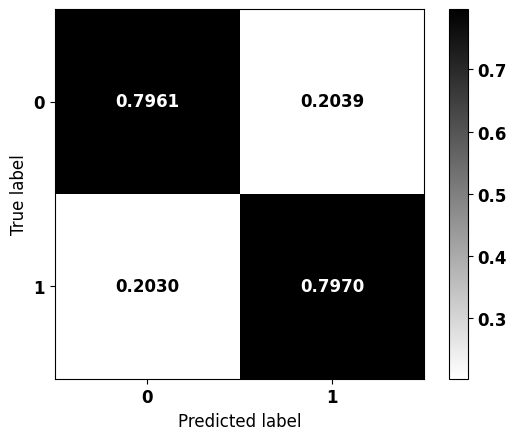


              precision    recall  f1-score   support

           0     0.6403    0.7961    0.7098     30576
           1     0.8959    0.7970    0.8436     67348

    accuracy                         0.7967     97924
   macro avg     0.7681    0.7965    0.7767     97924
weighted avg     0.8161    0.7967    0.8018     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.378

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

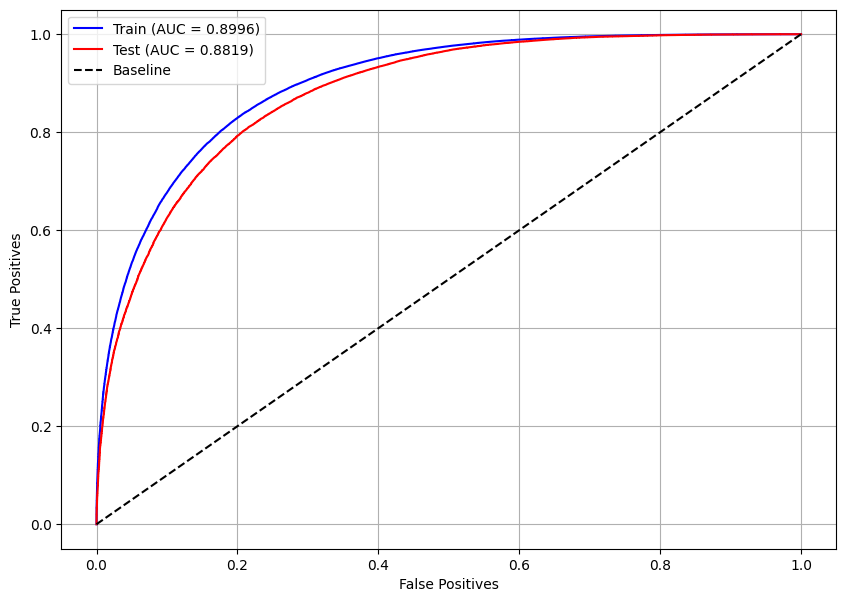

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 100,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.365, 0.385, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

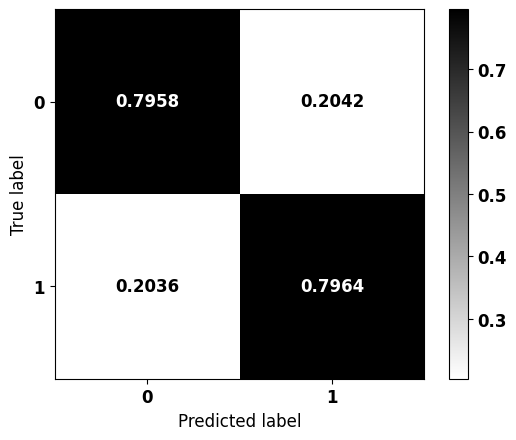


              precision    recall  f1-score   support

           0     0.6395    0.7958    0.7091     30576
           1     0.8957    0.7964    0.8431     67348

    accuracy                         0.7962     97924
   macro avg     0.7676    0.7961    0.7761     97924
weighted avg     0.8157    0.7962    0.8013     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3803
58/64
xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

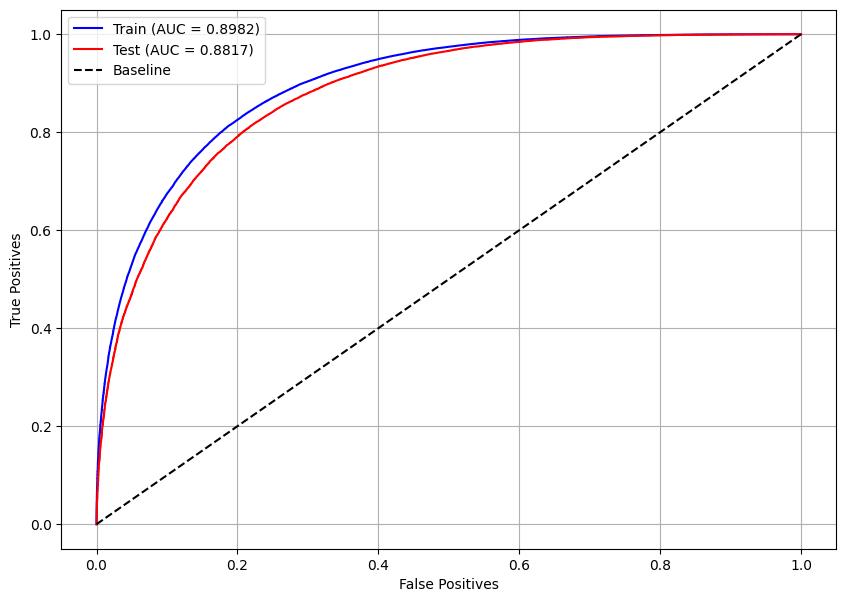

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_random, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


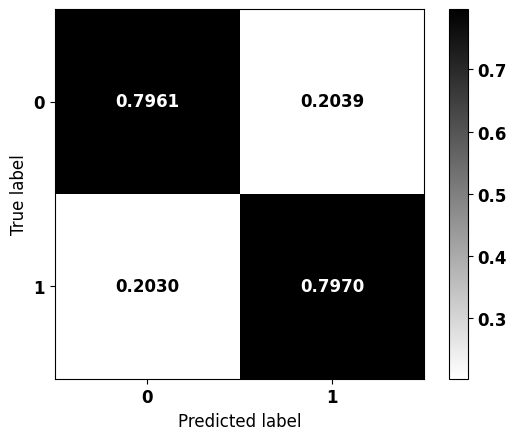


              precision    recall  f1-score   support

           0     0.6403    0.7961    0.7098     30576
           1     0.8959    0.7970    0.8436     67348

    accuracy                         0.7967     97924
   macro avg     0.7681    0.7965    0.7767     97924
weighted avg     0.8161    0.7967    0.8018     97924



In [ ]:
params = best.get_params()

# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

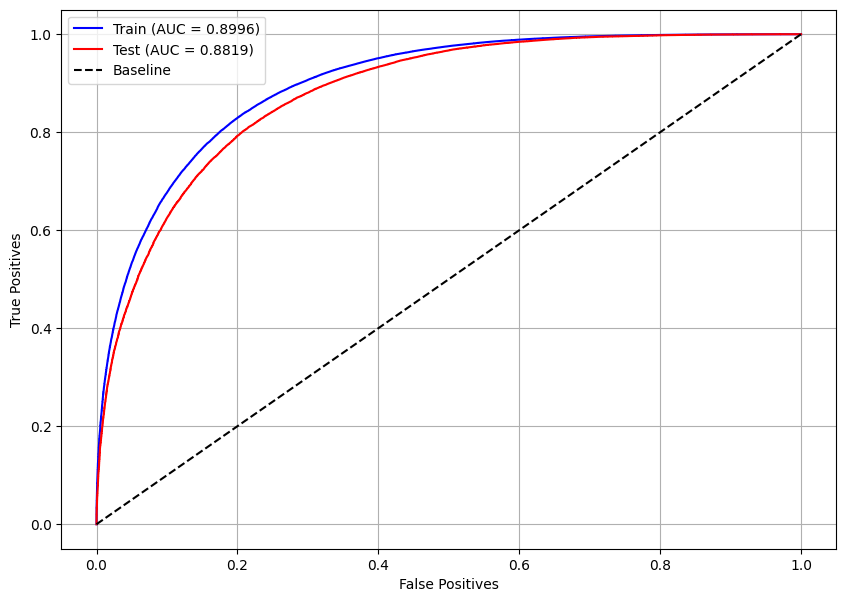

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

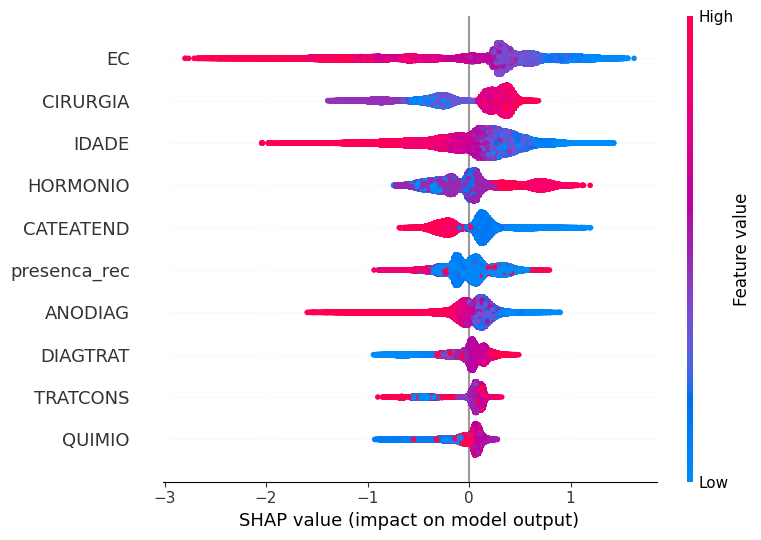

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

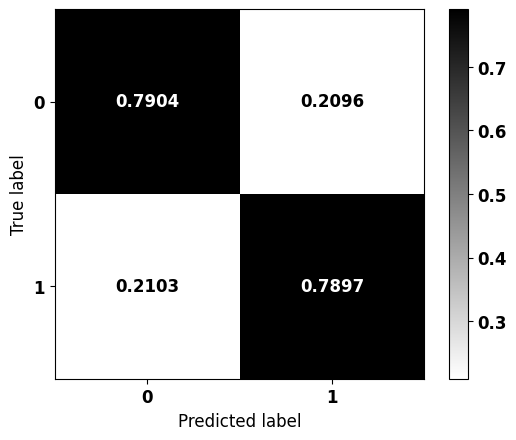


              precision    recall  f1-score   support

           0     0.6306    0.7904    0.7015     30576
           1     0.8925    0.7897    0.8380     67348

    accuracy                         0.7900     97924
   macro avg     0.7615    0.7901    0.7697     97924
weighted avg     0.8107    0.7900    0.7954     97924



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:2.56, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

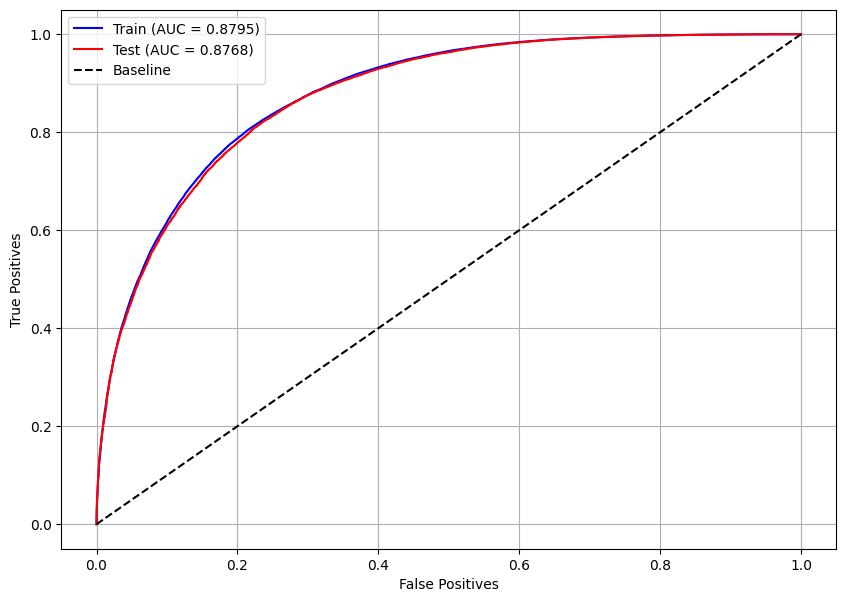

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


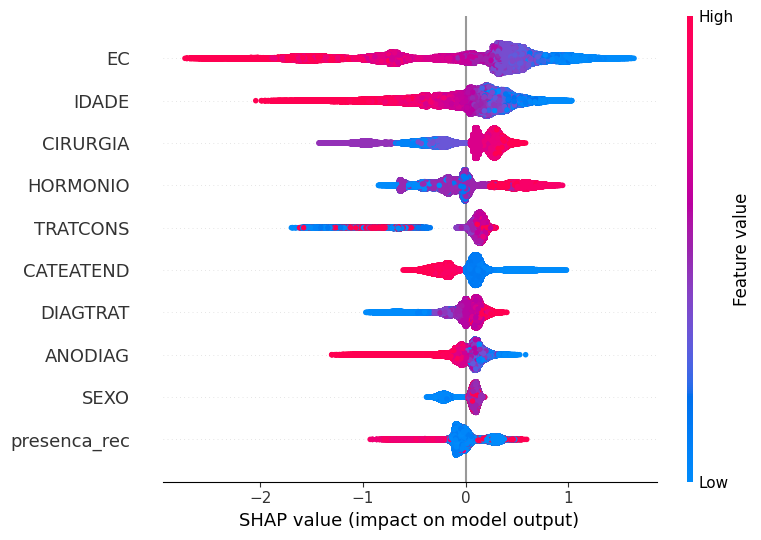

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 9,
 'learning_rate': 0.13,
 'min_child_weight': 7,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.55, 2.58, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

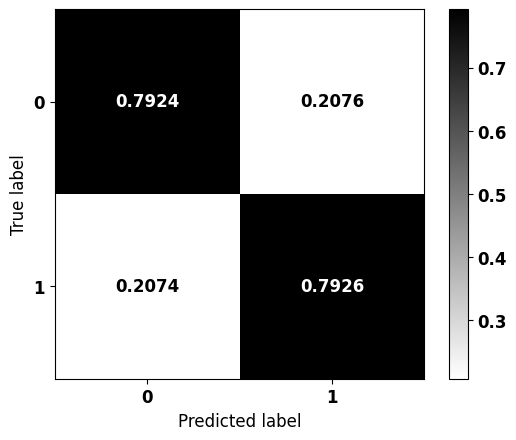


              precision    recall  f1-score   support

           0     0.6343    0.7924    0.7046     30576
           1     0.8937    0.7926    0.8401     67348

    accuracy                         0.7925     97924
   macro avg     0.7640    0.7925    0.7723     97924
weighted avg     0.8127    0.7925    0.7978     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.566, 1:1}

lgbm_random = LGBMClassifier(verbose=-1)
lgbm_random.set_params(**params)

lgbm_random.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_random, X_test, y_test)

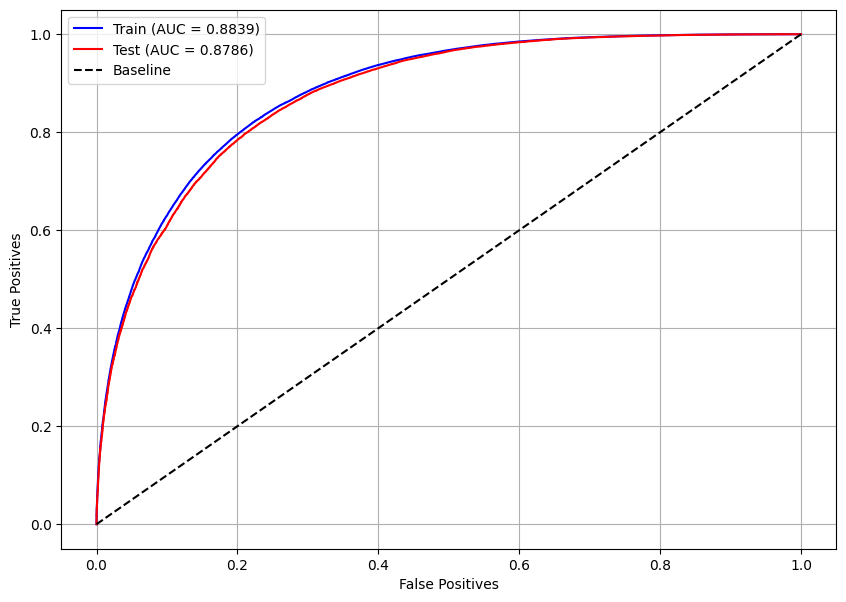

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 143,
 'max_depth': 9,
 'learning_rate': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.55, 2.58, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

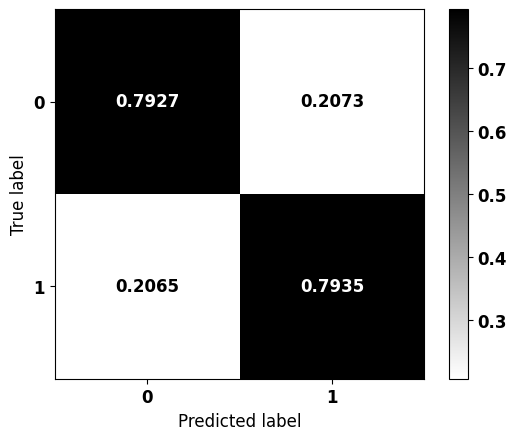


              precision    recall  f1-score   support

           0     0.6354    0.7927    0.7054     30576
           1     0.8940    0.7935    0.8408     67348

    accuracy                         0.7933     97924
   macro avg     0.7647    0.7931    0.7731     97924
weighted avg     0.8133    0.7933    0.7985     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.574, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

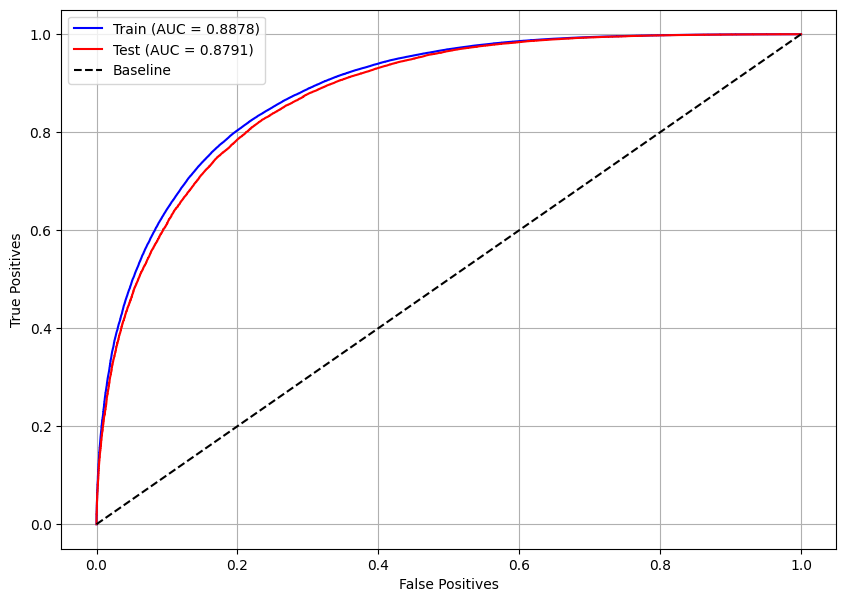

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 9,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(2.55, 2.58, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

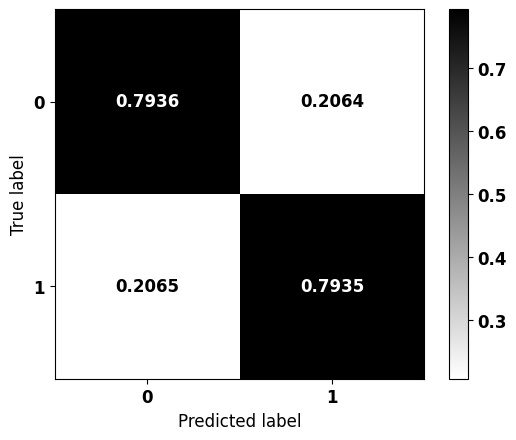


              precision    recall  f1-score   support

           0     0.6357    0.7936    0.7059     30576
           1     0.8944    0.7935    0.8410     67348

    accuracy                         0.7936     97924
   macro avg     0.7651    0.7936    0.7734     97924
weighted avg     0.8136    0.7936    0.7988     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.564, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

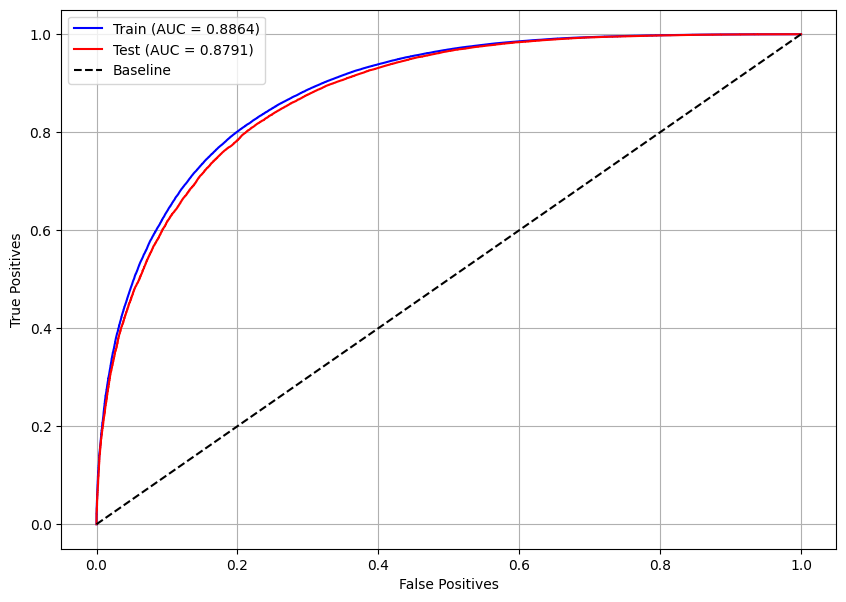

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_random, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 2.564, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.16999999999999998, max_depth=9,
               min_child_weight=4, n_estimators=150, random_state=7,
               verbose=-1)


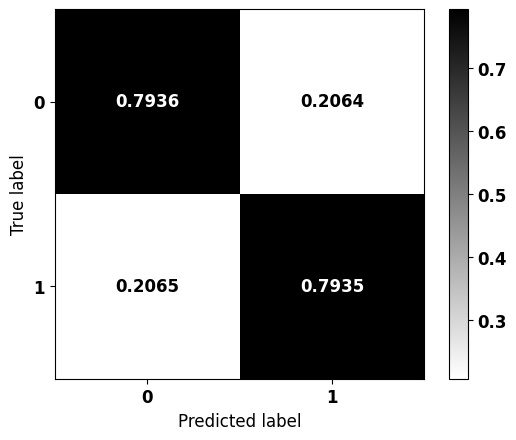


              precision    recall  f1-score   support

           0     0.6357    0.7936    0.7059     30576
           1     0.8944    0.7935    0.8410     67348

    accuracy                         0.7936     97924
   macro avg     0.7651    0.7936    0.7734     97924
weighted avg     0.8136    0.7936    0.7988     97924



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

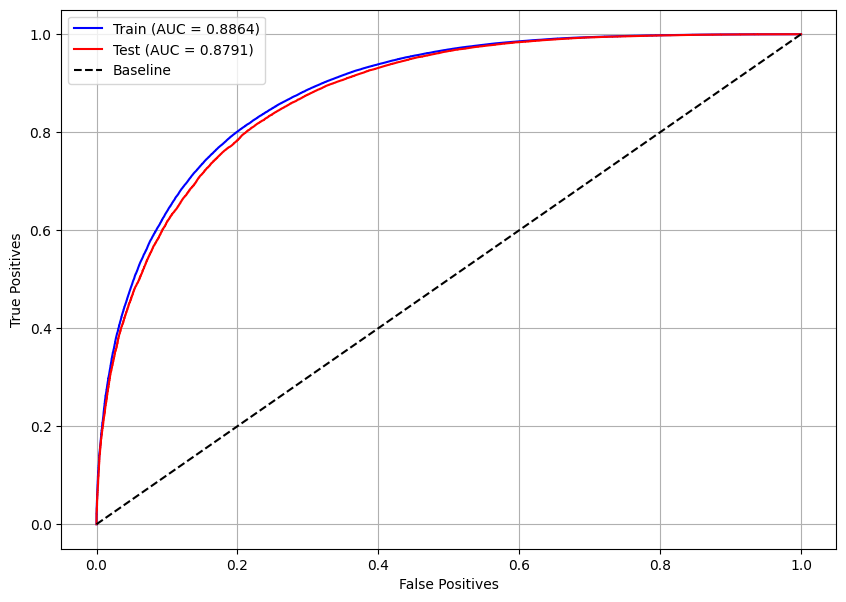

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

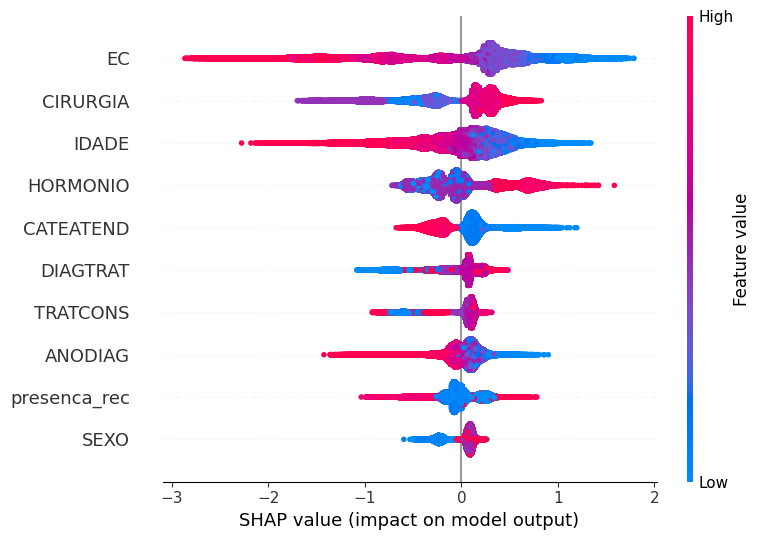

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


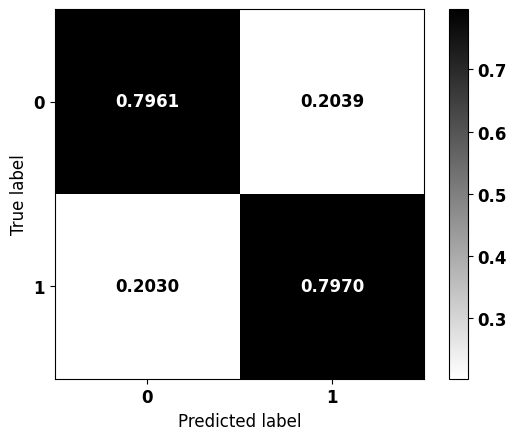


              precision    recall  f1-score   support

           0     0.6403    0.7961    0.7098     30576
           1     0.8959    0.7970    0.8436     67348

    accuracy                         0.7967     97924
   macro avg     0.7681    0.7965    0.7767     97924
weighted avg     0.8161    0.7967    0.8018     97924



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

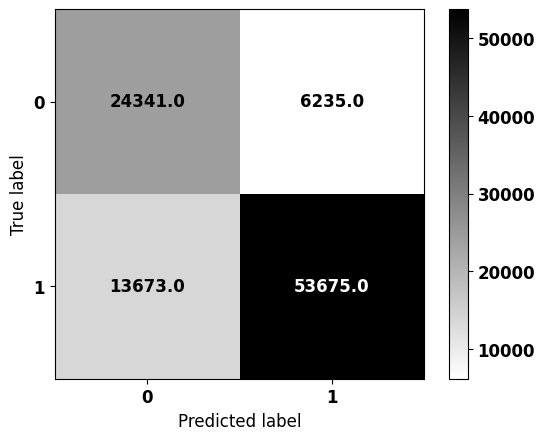


              precision    recall  f1-score   support

           0     0.6403    0.7961    0.7098     30576
           1     0.8959    0.7970    0.8436     67348

    accuracy                         0.7967     97924
   macro avg     0.7681    0.7965    0.7767     97924
weighted avg     0.8161    0.7967    0.8018     97924



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

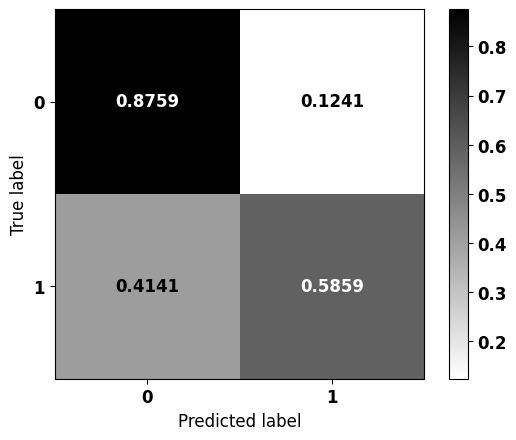


              precision    recall  f1-score   support

           0     0.6384    0.8759    0.7385      6182
           1     0.8498    0.5859    0.6936      7406

    accuracy                         0.7178     13588
   macro avg     0.7441    0.7309    0.7161     13588
weighted avg     0.7536    0.7178    0.7140     13588



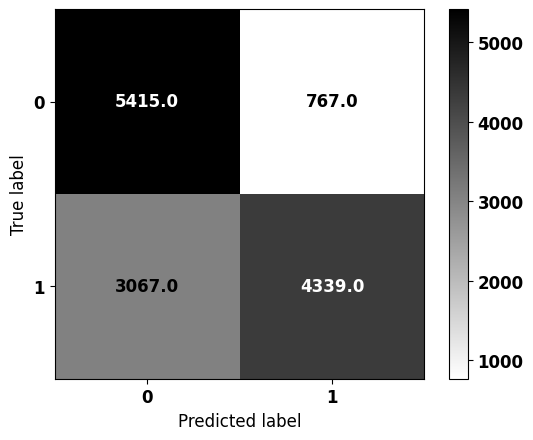


              precision    recall  f1-score   support

           0     0.6384    0.8759    0.7385      6182
           1     0.8498    0.5859    0.6936      7406

    accuracy                         0.7178     13588
   macro avg     0.7441    0.7309    0.7161     13588
weighted avg     0.7536    0.7178    0.7140     13588



In [ ]:
# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

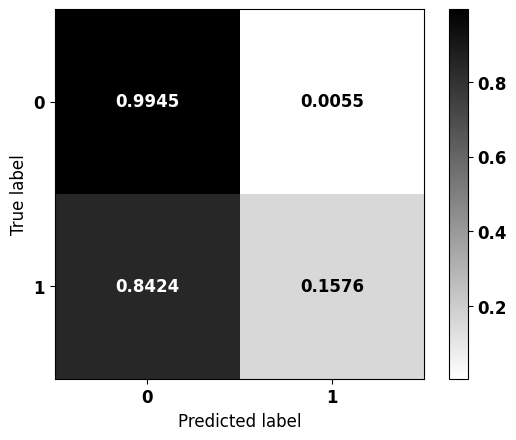


              precision    recall  f1-score   support

           0     0.8866    0.9945    0.9374      7939
           1     0.8112    0.1576    0.2640      1199

    accuracy                         0.8847      9138
   macro avg     0.8489    0.5760    0.6007      9138
weighted avg     0.8767    0.8847    0.8491      9138



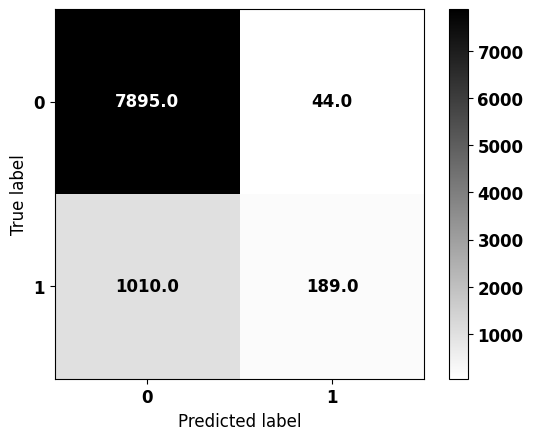


              precision    recall  f1-score   support

           0     0.8866    0.9945    0.9374      7939
           1     0.8112    0.1576    0.2640      1199

    accuracy                         0.8847      9138
   macro avg     0.8489    0.5760    0.6007      9138
weighted avg     0.8767    0.8847    0.8491      9138



In [ ]:
# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

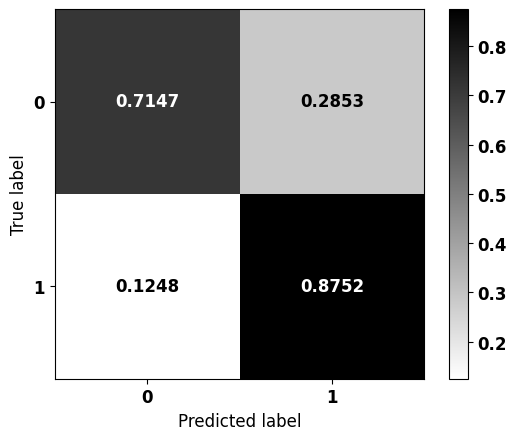


              precision    recall  f1-score   support

           0     0.5930    0.7147    0.6482      5117
           1     0.9234    0.8752    0.8987     20115

    accuracy                         0.8427     25232
   macro avg     0.7582    0.7949    0.7734     25232
weighted avg     0.8564    0.8427    0.8479     25232



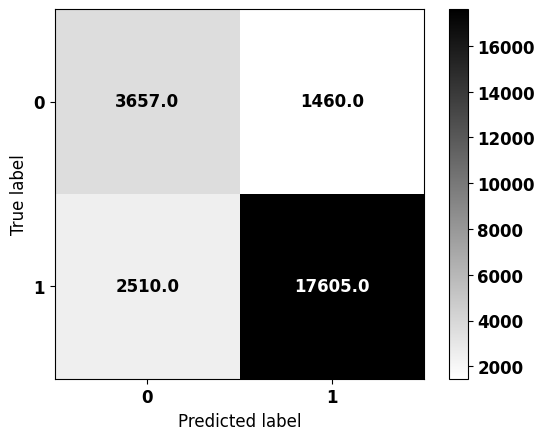


              precision    recall  f1-score   support

           0     0.5930    0.7147    0.6482      5117
           1     0.9234    0.8752    0.8987     20115

    accuracy                         0.8427     25232
   macro avg     0.7582    0.7949    0.7734     25232
weighted avg     0.8564    0.8427    0.8479     25232



In [ ]:
# Mama
X_test_mama = mama_teste.drop(columns=list_drop).copy()
y_test_mama = mama_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_mama, y_test_mama)
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

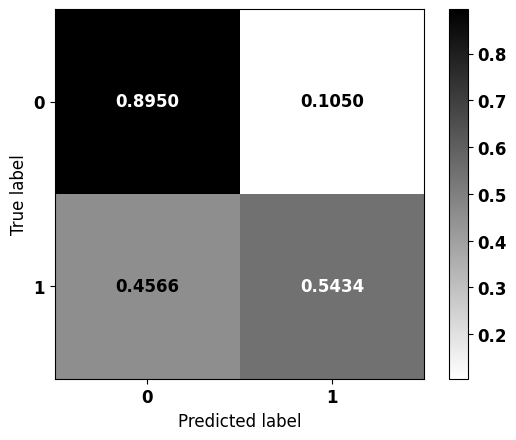


              precision    recall  f1-score   support

           0     0.6023    0.8950    0.7200      2286
           1     0.8701    0.5434    0.6690      2959

    accuracy                         0.6967      5245
   macro avg     0.7362    0.7192    0.6945      5245
weighted avg     0.7534    0.6967    0.6913      5245



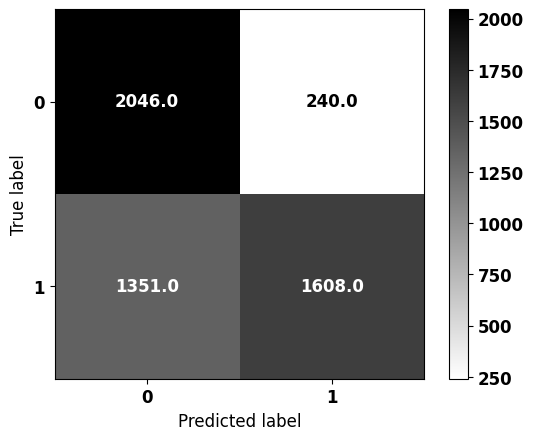


              precision    recall  f1-score   support

           0     0.6023    0.8950    0.7200      2286
           1     0.8701    0.5434    0.6690      2959

    accuracy                         0.6967      5245
   macro avg     0.7362    0.7192    0.6945      5245
weighted avg     0.7534    0.6967    0.6913      5245



In [ ]:
# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

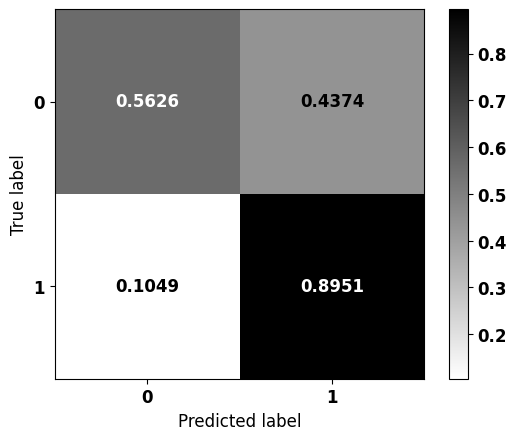


              precision    recall  f1-score   support

           0     0.5136    0.5626    0.5370      3315
           1     0.9122    0.8951    0.9035     16829

    accuracy                         0.8403     20144
   macro avg     0.7129    0.7288    0.7203     20144
weighted avg     0.8466    0.8403    0.8432     20144



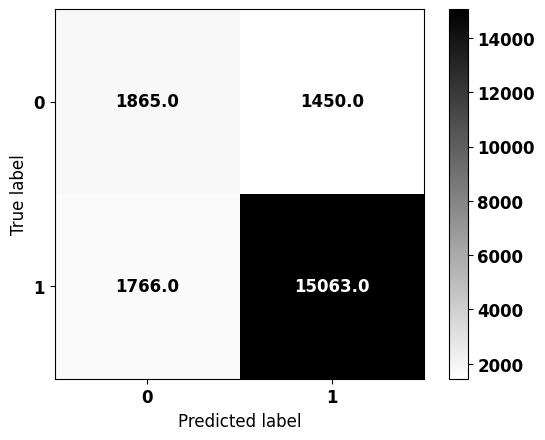


              precision    recall  f1-score   support

           0     0.5136    0.5626    0.5370      3315
           1     0.9122    0.8951    0.9035     16829

    accuracy                         0.8403     20144
   macro avg     0.7129    0.7288    0.7203     20144
weighted avg     0.8466    0.8403    0.8432     20144



In [ ]:
# Próstata
X_test_prost = prost_teste.drop(columns=list_drop).copy()
y_test_prost = prost_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_prost, y_test_prost)
plot_confusion_matrix(best, X_test_prost, y_test_prost, norm=False)

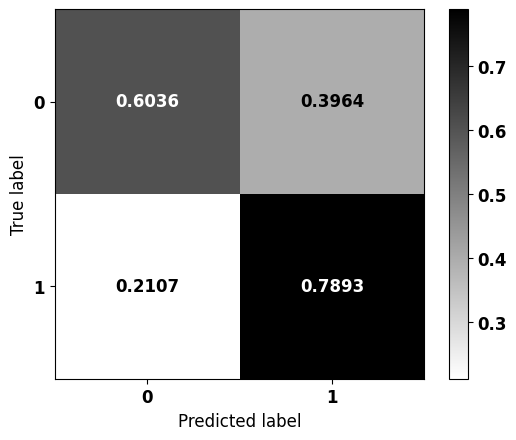


              precision    recall  f1-score   support

           0     0.4660    0.6036    0.5259      5737
           1     0.8674    0.7893    0.8265     18840

    accuracy                         0.7460     24577
   macro avg     0.6667    0.6965    0.6762     24577
weighted avg     0.7737    0.7460    0.7563     24577



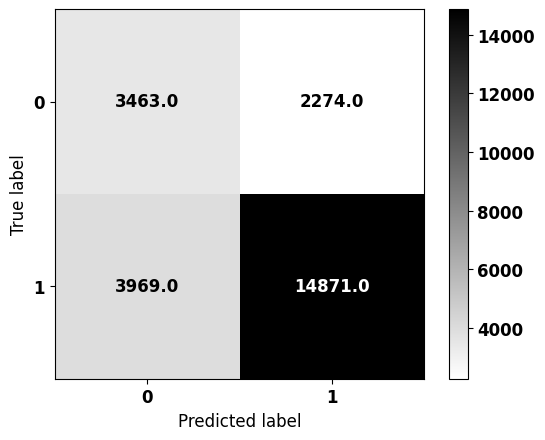


              precision    recall  f1-score   support

           0     0.4660    0.6036    0.5259      5737
           1     0.8674    0.7893    0.8265     18840

    accuracy                         0.7460     24577
   macro avg     0.6667    0.6965    0.6762     24577
weighted avg     0.7737    0.7460    0.7563     24577



In [ ]:
# Pele
X_test_pele = pele_teste.drop(columns=list_drop).copy()
y_test_pele = pele_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pele, y_test_pele)
plot_confusion_matrix(best, X_test_pele, y_test_pele, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7942, Optuna = 0.7967

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7900, Optuna = 0.7936

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 2.564, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.17, max_depth=9, min_child_weight=4,
               n_estimators=150, random_state=7, verbose=-1)

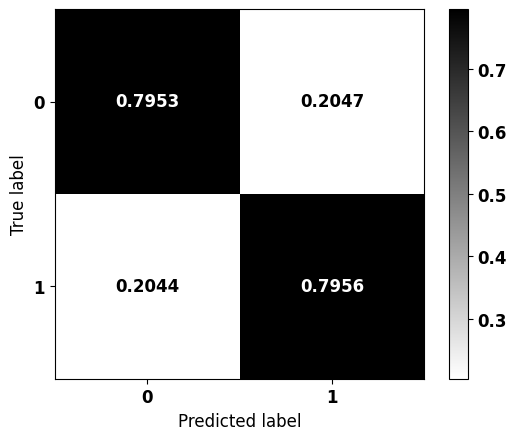


              precision    recall  f1-score   support

           0     0.6386    0.7953    0.7084     30576
           1     0.8954    0.7956    0.8426     67348

    accuracy                         0.7955     97924
   macro avg     0.7670    0.7955    0.7755     97924
weighted avg     0.8152    0.7955    0.8007     97924



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

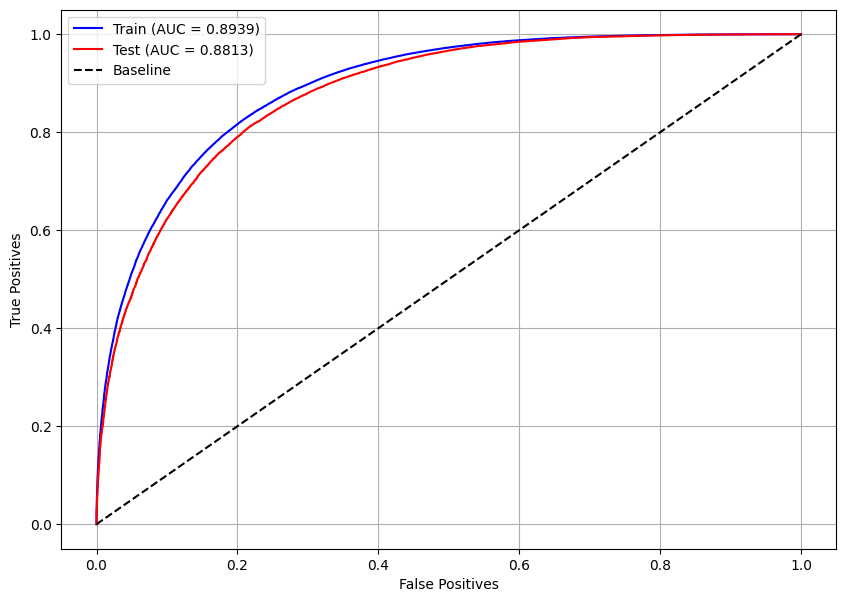

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Mais incidentes Juntos**

**Com TOPOGRUP**

## **Pré-processamento**

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_incid_treino['TOPOGRUP'] = ss.fit_transform(df_incid_treino[['TOPOGRUP']])
df_incid_teste['TOPOGRUP'] = ss.transform(df_incid_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_incid_treino.drop(columns=list_drop).copy()
y_train = df_incid_treino.sobrevida_3anos.copy()

# Teste
X_test = df_incid_teste.drop(columns=list_drop).copy()
y_test = df_incid_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((293766, 26), (293766,), (97924, 26), (97924,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

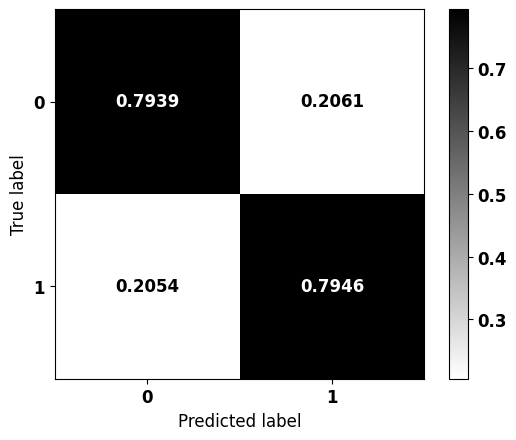


              precision    recall  f1-score   support

           0     0.6370    0.7939    0.7069     30576
           1     0.8947    0.7946    0.8417     67348

    accuracy                         0.7944     97924
   macro avg     0.7658    0.7943    0.7743     97924
weighted avg     0.8142    0.7944    0.7996     97924



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=7,
                    scale_pos_weight=0.3754,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

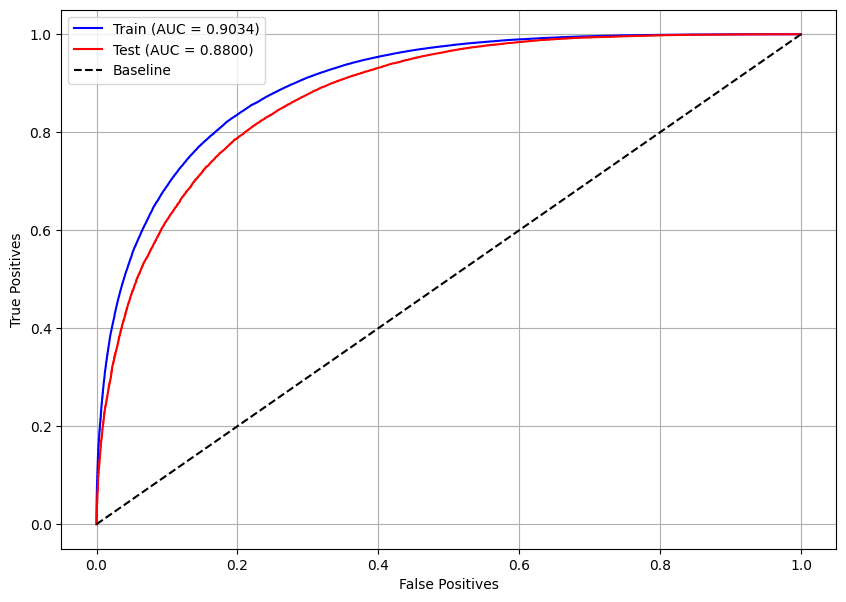

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

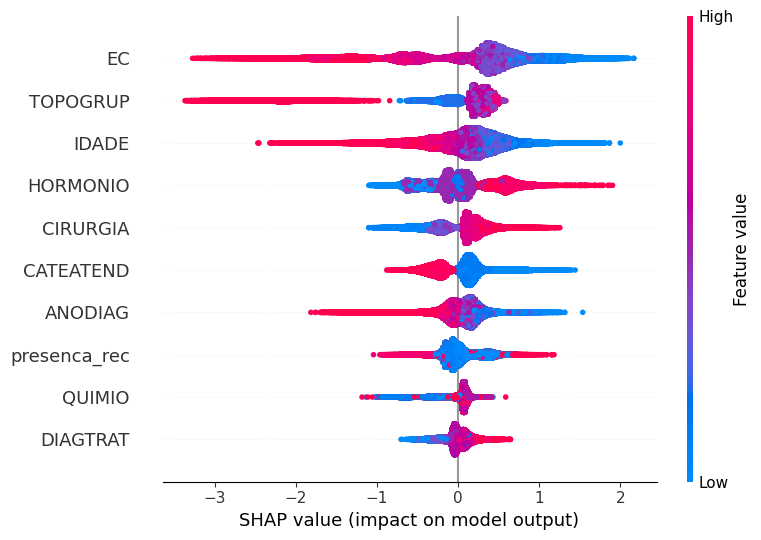

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.3735, 0.378, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

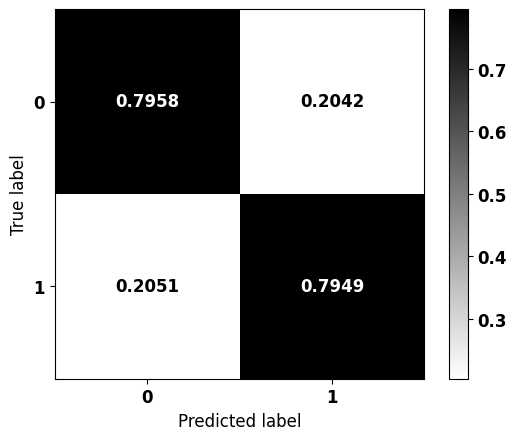


              precision    recall  f1-score   support

           0     0.6379    0.7958    0.7082     30576
           1     0.8956    0.7949    0.8422     67348

    accuracy                         0.7952     97924
   macro avg     0.7667    0.7954    0.7752     97924
weighted avg     0.8151    0.7952    0.8004     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3742

xgb_random = XGBClassifier()
xgb_random.set_params(**params)

xgb_random.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_random, X_test, y_test)

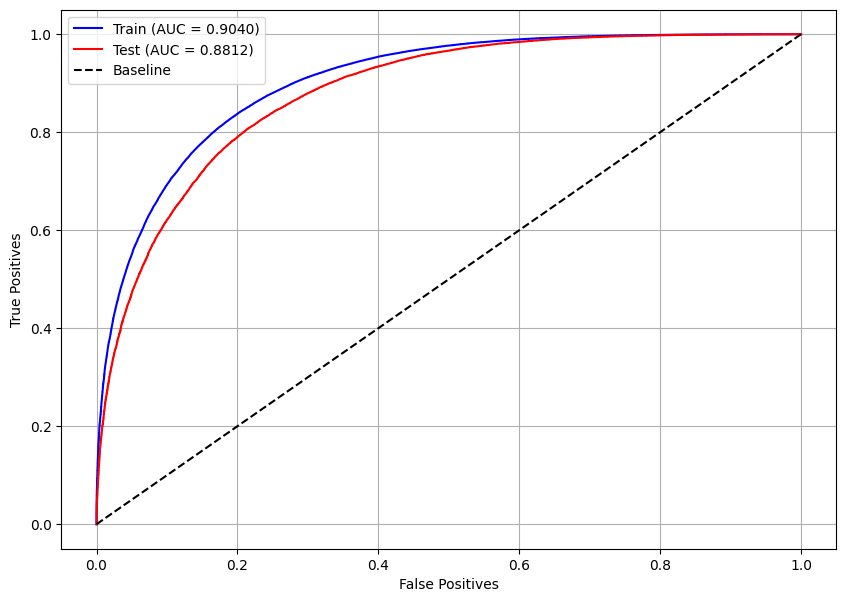

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 146,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.3735, 0.377, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

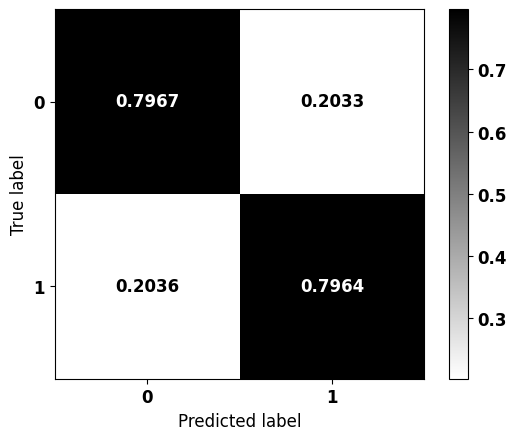


              precision    recall  f1-score   support

           0     0.6398    0.7967    0.7097     30576
           1     0.8962    0.7964    0.8433     67348

    accuracy                         0.7965     97924
   macro avg     0.7680    0.7966    0.7765     97924
weighted avg     0.8161    0.7965    0.8016     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3755

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

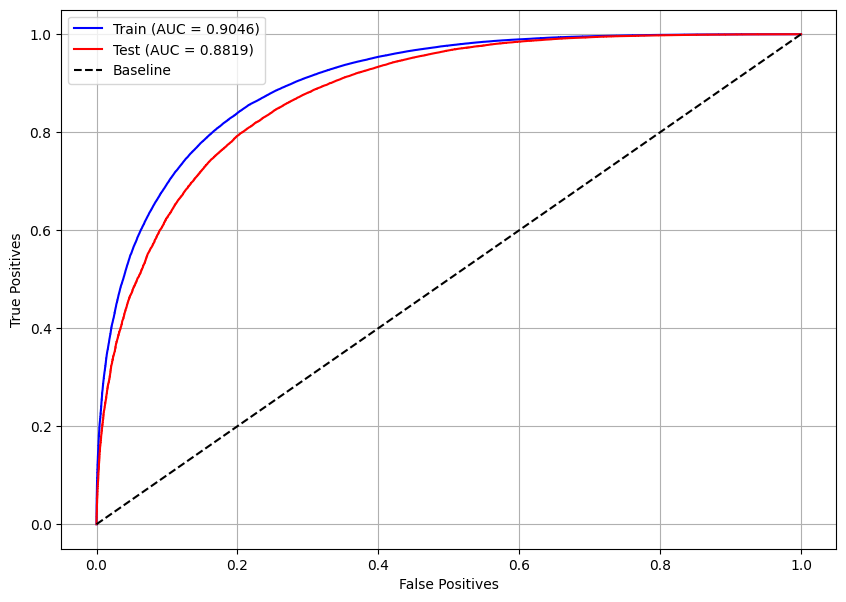

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 139,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 2,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.3735, 0.377, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

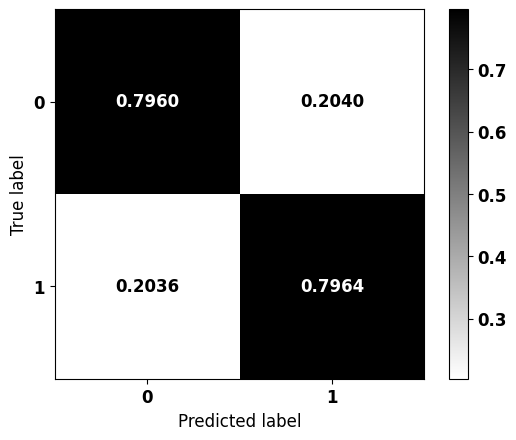


              precision    recall  f1-score   support

           0     0.6396    0.7960    0.7093     30576
           1     0.8958    0.7964    0.8432     67348

    accuracy                         0.7963     97924
   macro avg     0.7677    0.7962    0.7763     97924
weighted avg     0.8158    0.7963    0.8014     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3765

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

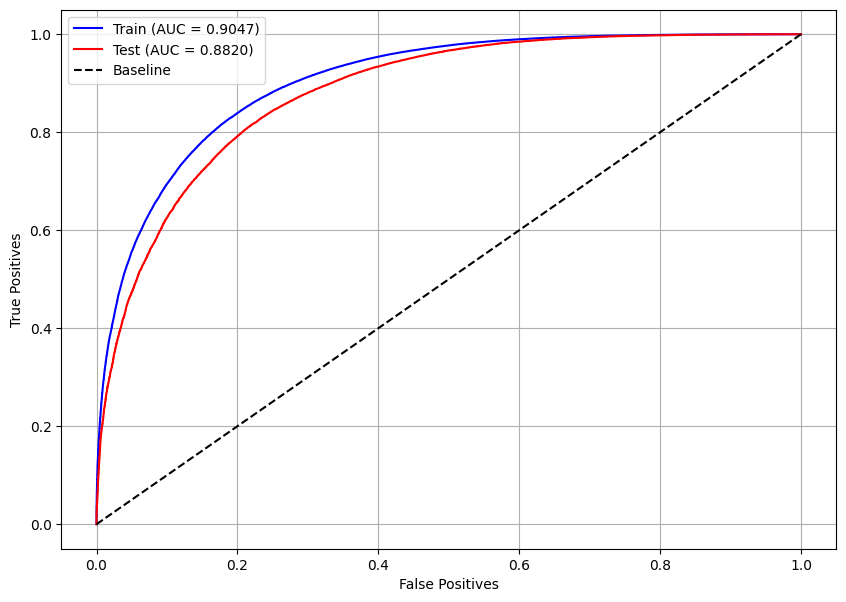

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_random, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


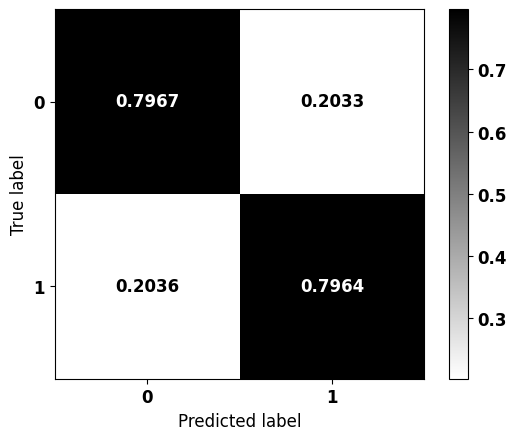


              precision    recall  f1-score   support

           0     0.6398    0.7967    0.7097     30576
           1     0.8962    0.7964    0.8433     67348

    accuracy                         0.7965     97924
   macro avg     0.7680    0.7966    0.7765     97924
weighted avg     0.8161    0.7965    0.8016     97924



In [ ]:
params = best.get_params()

# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

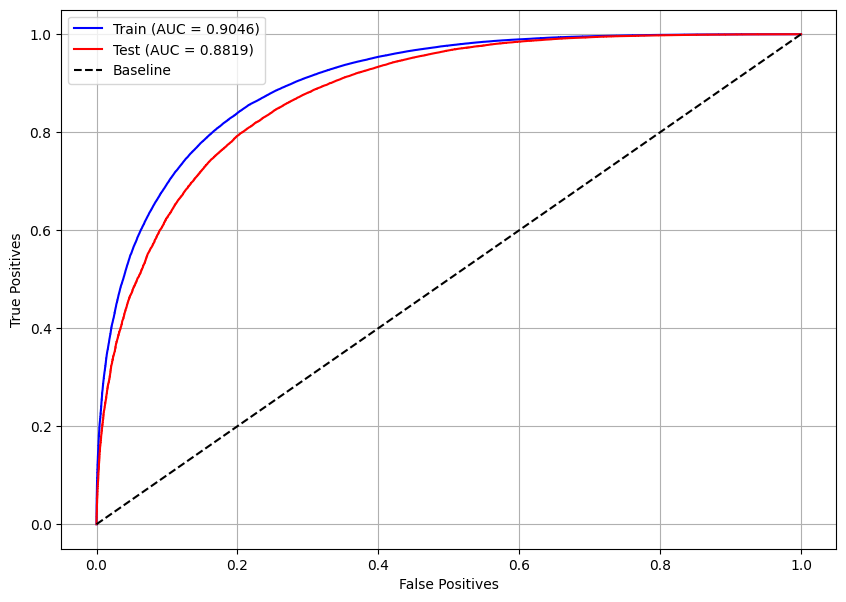

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

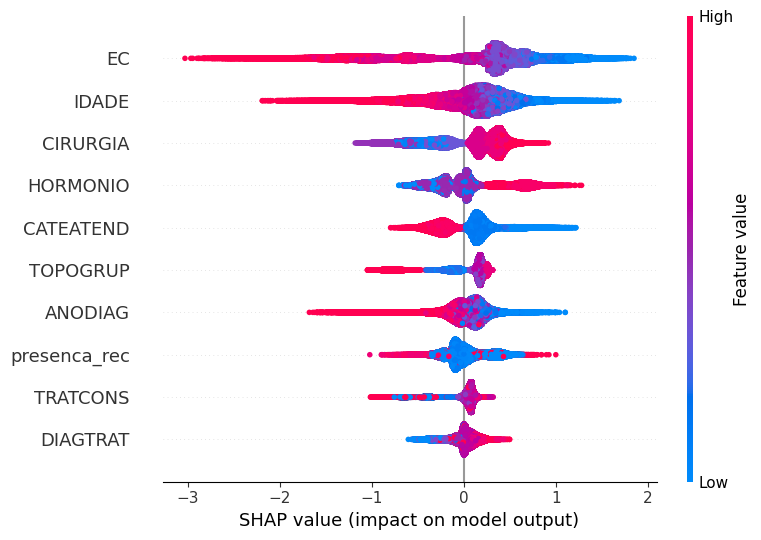

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

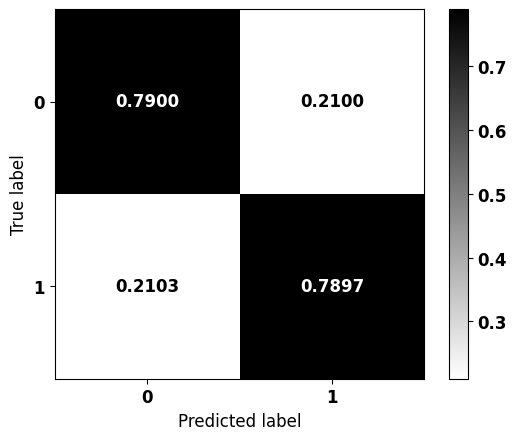


              precision    recall  f1-score   support

           0     0.6304    0.7900    0.7012     30576
           1     0.8923    0.7897    0.8379     67348

    accuracy                         0.7898     97924
   macro avg     0.7613    0.7898    0.7695     97924
weighted avg     0.8105    0.7898    0.7952     97924



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:2.525, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

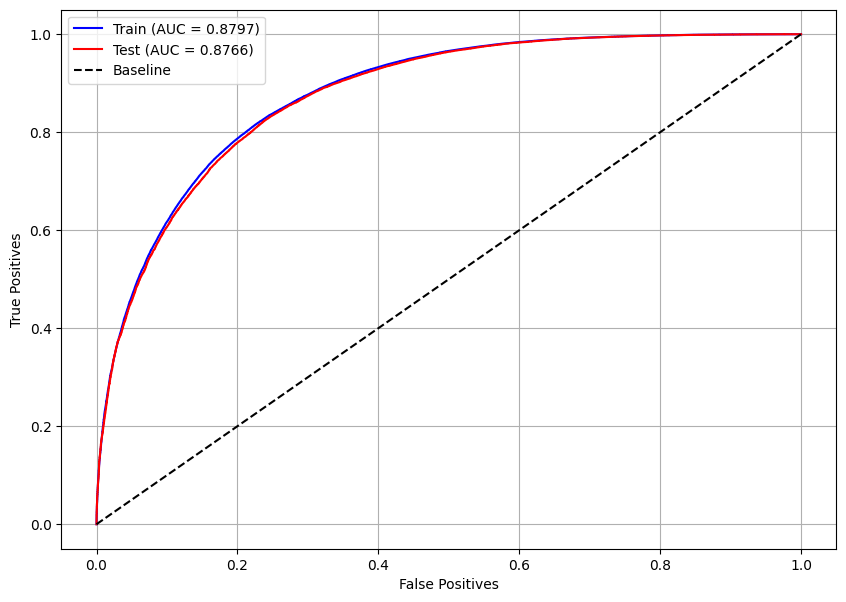

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


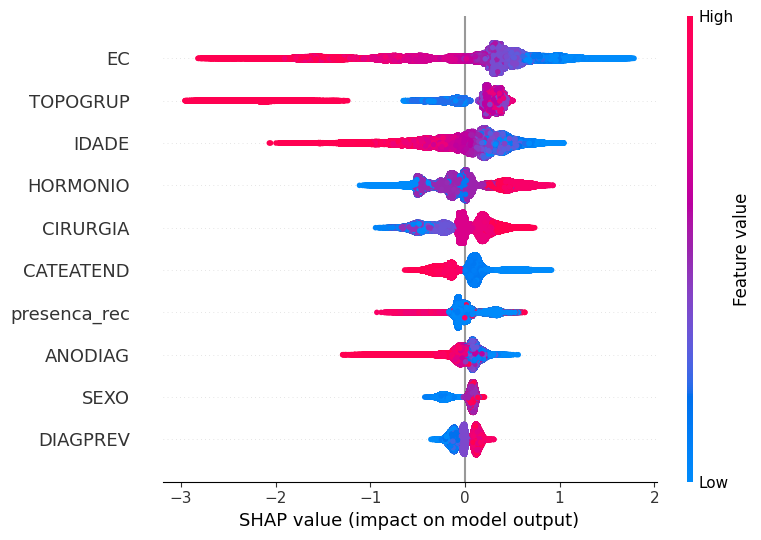

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 147,
 'max_depth': 9,
 'learning_rate': 0.19,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.585, 2.61, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

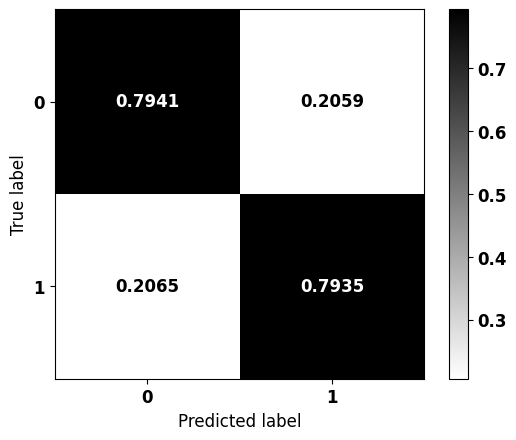


              precision    recall  f1-score   support

           0     0.6358    0.7941    0.7062     30576
           1     0.8946    0.7935    0.8410     67348

    accuracy                         0.7937     97924
   macro avg     0.7652    0.7938    0.7736     97924
weighted avg     0.8138    0.7937    0.7989     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.605, 1:1}

lgbm_random = LGBMClassifier(verbose=-1)
lgbm_random.set_params(**params)

lgbm_random.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_random, X_test, y_test)

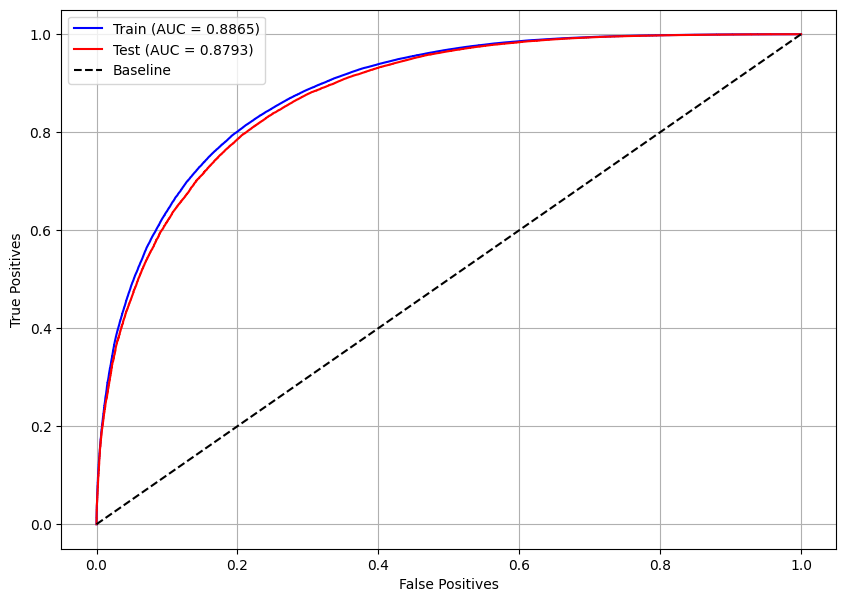

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 147,
 'max_depth': 9,
 'learning_rate': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(2.555, 2.59, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

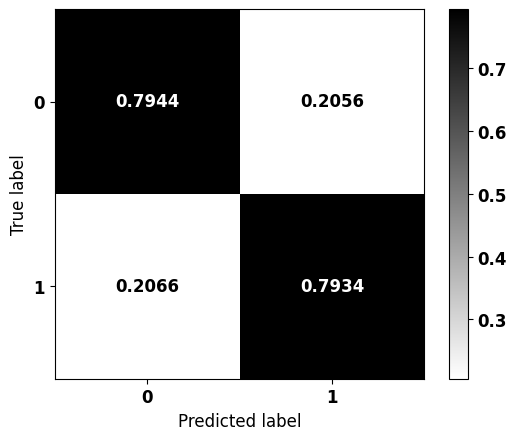


              precision    recall  f1-score   support

           0     0.6358    0.7944    0.7063     30576
           1     0.8947    0.7934    0.8410     67348

    accuracy                         0.7937     97924
   macro avg     0.7653    0.7939    0.7737     97924
weighted avg     0.8139    0.7937    0.7990     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.588, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

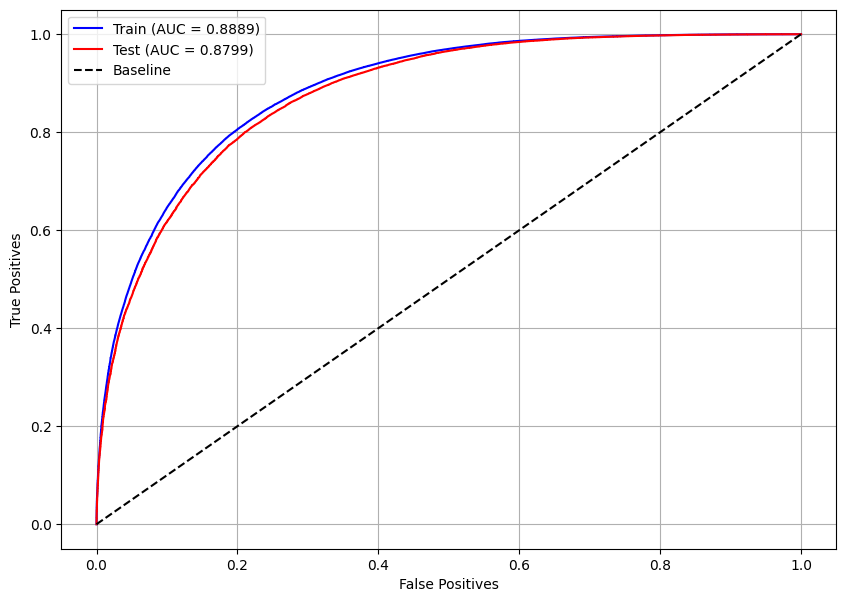

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 145,
 'max_depth': 8,
 'learning_rate': 0.18,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(2.555, 2.59, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

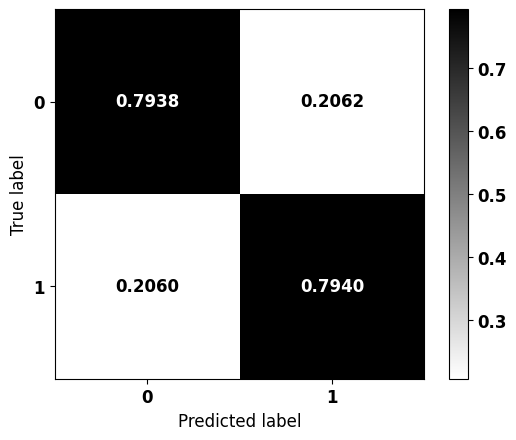


              precision    recall  f1-score   support

           0     0.6363    0.7938    0.7064     30576
           1     0.8945    0.7940    0.8413     67348

    accuracy                         0.7939     97924
   macro avg     0.7654    0.7939    0.7738     97924
weighted avg     0.8139    0.7939    0.7992     97924



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.574, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

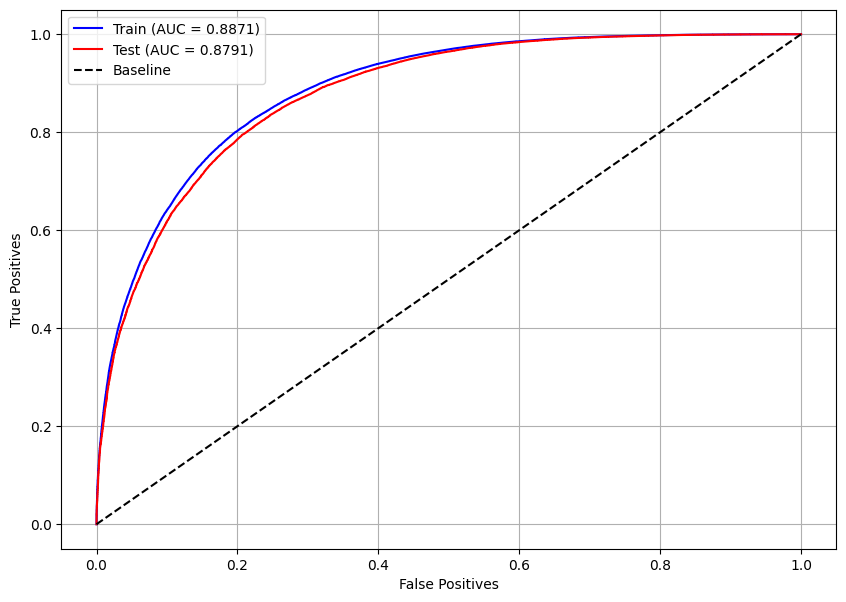

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_random, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 2.574, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.18, max_depth=8, min_child_weight=7,
               n_estimators=145, random_state=7, verbose=-1)


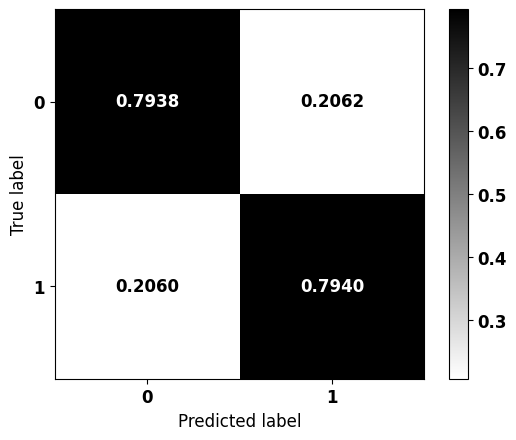


              precision    recall  f1-score   support

           0     0.6363    0.7938    0.7064     30576
           1     0.8945    0.7940    0.8413     67348

    accuracy                         0.7939     97924
   macro avg     0.7654    0.7939    0.7738     97924
weighted avg     0.8139    0.7939    0.7992     97924



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

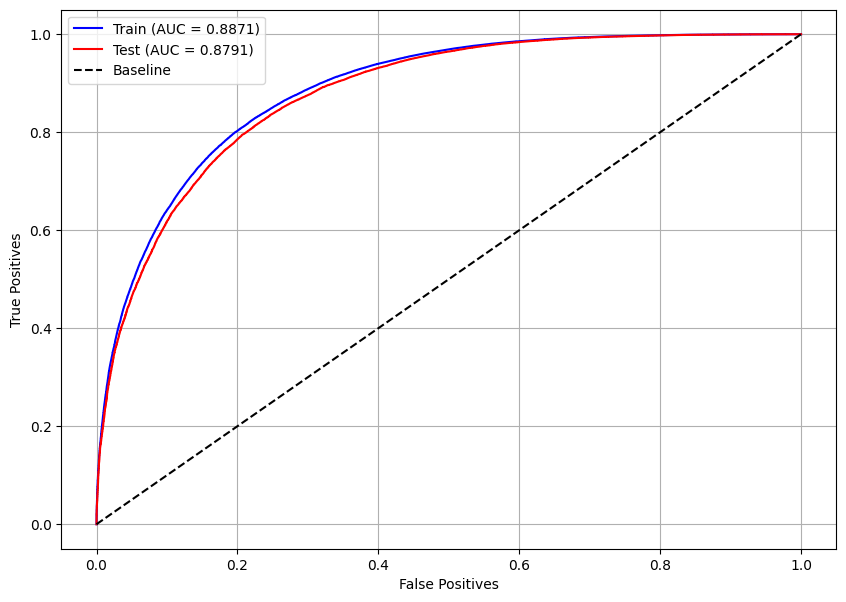

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


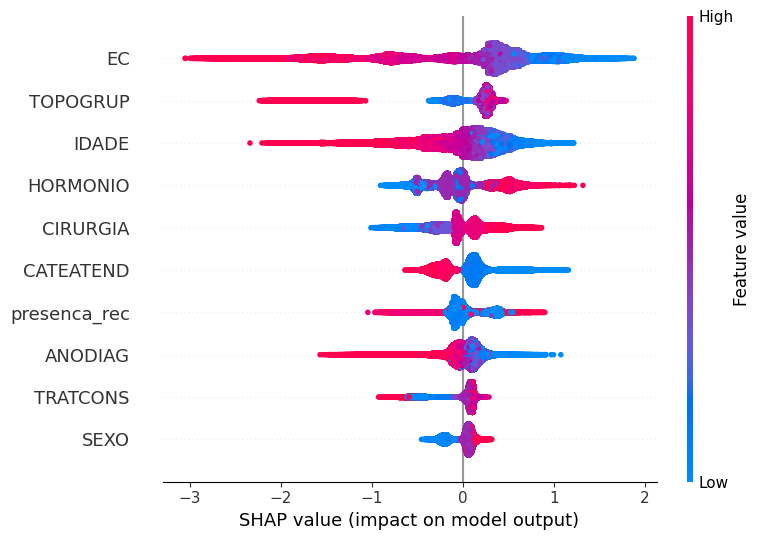

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


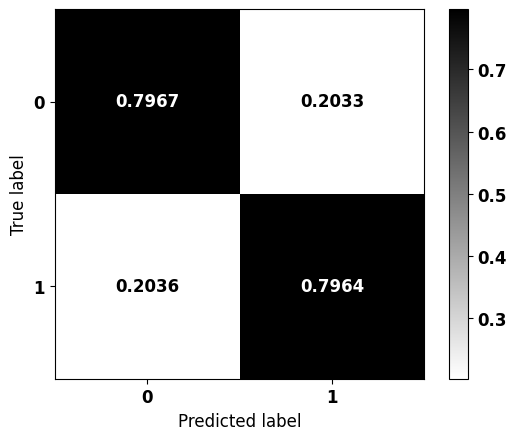


              precision    recall  f1-score   support

           0     0.6398    0.7967    0.7097     30576
           1     0.8962    0.7964    0.8433     67348

    accuracy                         0.7965     97924
   macro avg     0.7680    0.7966    0.7765     97924
weighted avg     0.8161    0.7965    0.8016     97924



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

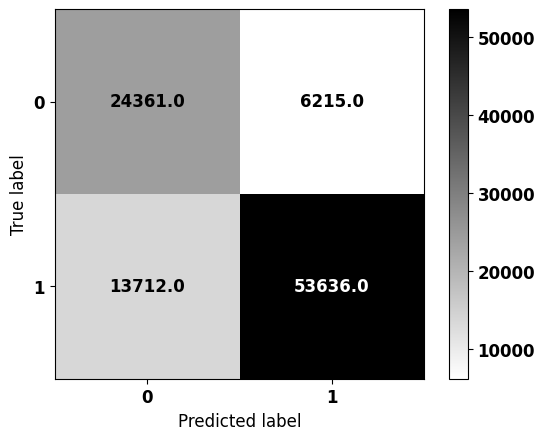


              precision    recall  f1-score   support

           0     0.6398    0.7967    0.7097     30576
           1     0.8962    0.7964    0.8433     67348

    accuracy                         0.7965     97924
   macro avg     0.7680    0.7966    0.7765     97924
weighted avg     0.8161    0.7965    0.8016     97924



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
dfs = [colo_utero_teste, colo_teste, mama_teste, pele_teste, prost_teste, pulm_teste]

for df in dfs:
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

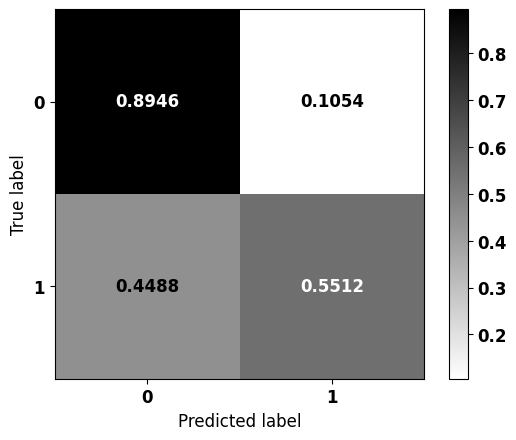


              precision    recall  f1-score   support

           0     0.6063    0.8946    0.7227      2286
           1     0.8713    0.5512    0.6752      2959

    accuracy                         0.7009      5245
   macro avg     0.7388    0.7229    0.6990      5245
weighted avg     0.7558    0.7009    0.6959      5245



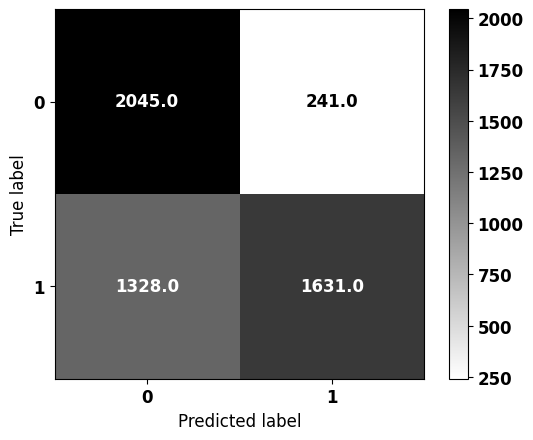


              precision    recall  f1-score   support

           0     0.6063    0.8946    0.7227      2286
           1     0.8713    0.5512    0.6752      2959

    accuracy                         0.7009      5245
   macro avg     0.7388    0.7229    0.6990      5245
weighted avg     0.7558    0.7009    0.6959      5245



In [ ]:
# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

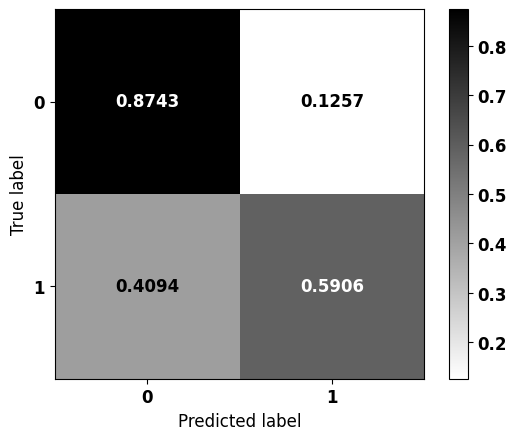


              precision    recall  f1-score   support

           0     0.6406    0.8743    0.7394      6182
           1     0.8492    0.5906    0.6967      7406

    accuracy                         0.7197     13588
   macro avg     0.7449    0.7325    0.7181     13588
weighted avg     0.7543    0.7197    0.7161     13588



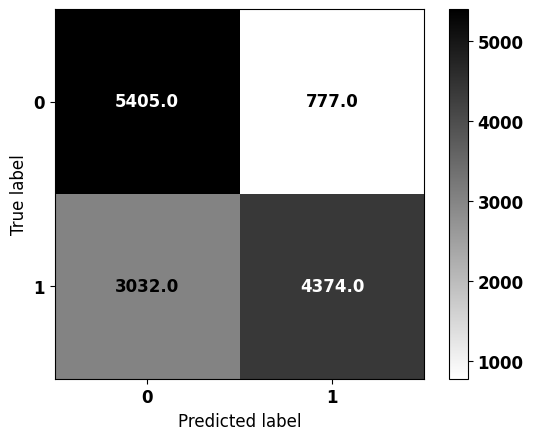


              precision    recall  f1-score   support

           0     0.6406    0.8743    0.7394      6182
           1     0.8492    0.5906    0.6967      7406

    accuracy                         0.7197     13588
   macro avg     0.7449    0.7325    0.7181     13588
weighted avg     0.7543    0.7197    0.7161     13588



In [ ]:
# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

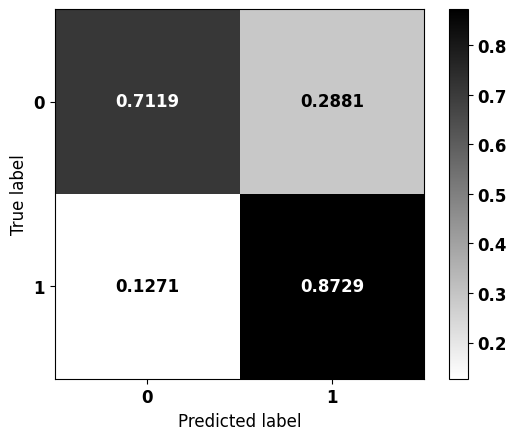


              precision    recall  f1-score   support

           0     0.5877    0.7119    0.6439      5117
           1     0.9226    0.8729    0.8971     20115

    accuracy                         0.8403     25232
   macro avg     0.7551    0.7924    0.7705     25232
weighted avg     0.8546    0.8403    0.8457     25232



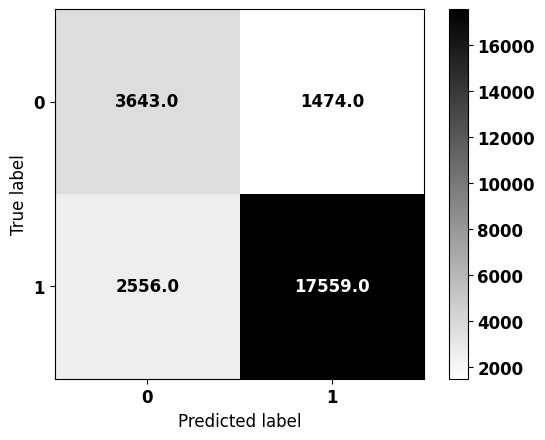


              precision    recall  f1-score   support

           0     0.5877    0.7119    0.6439      5117
           1     0.9226    0.8729    0.8971     20115

    accuracy                         0.8403     25232
   macro avg     0.7551    0.7924    0.7705     25232
weighted avg     0.8546    0.8403    0.8457     25232



In [ ]:
# Mama
X_test_mama = mama_teste.drop(columns=list_drop).copy()
y_test_mama = mama_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_mama, y_test_mama)
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

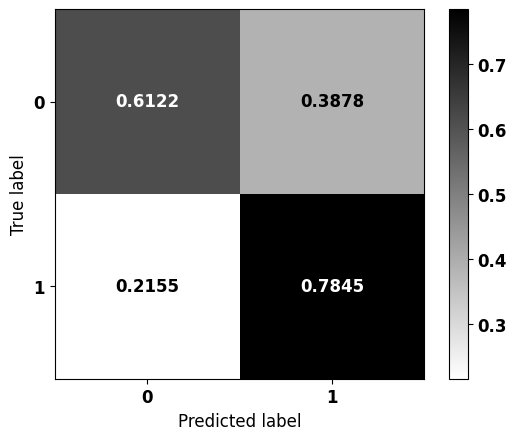


              precision    recall  f1-score   support

           0     0.4638    0.6122    0.5278      5737
           1     0.8692    0.7845    0.8247     18840

    accuracy                         0.7443     24577
   macro avg     0.6665    0.6983    0.6762     24577
weighted avg     0.7745    0.7443    0.7554     24577



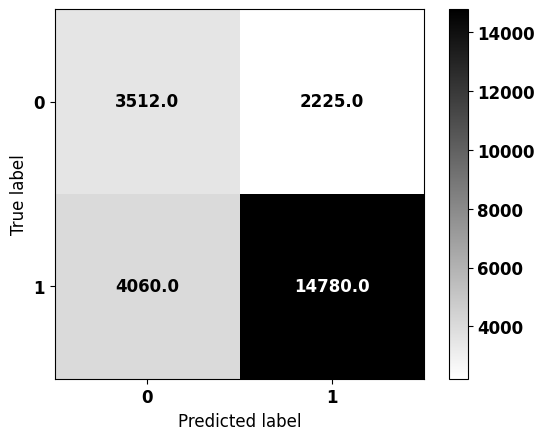


              precision    recall  f1-score   support

           0     0.4638    0.6122    0.5278      5737
           1     0.8692    0.7845    0.8247     18840

    accuracy                         0.7443     24577
   macro avg     0.6665    0.6983    0.6762     24577
weighted avg     0.7745    0.7443    0.7554     24577



In [ ]:
# Pele
X_test_pele = pele_teste.drop(columns=list_drop).copy()
y_test_pele = pele_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pele, y_test_pele)
plot_confusion_matrix(best, X_test_pele, y_test_pele, norm=False)

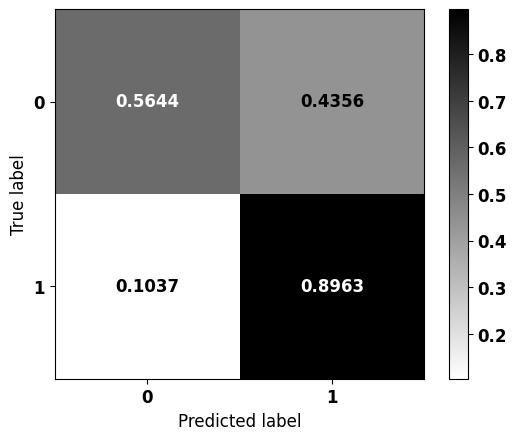


              precision    recall  f1-score   support

           0     0.5173    0.5644    0.5398      3315
           1     0.9126    0.8963    0.9044     16829

    accuracy                         0.8416     20144
   macro avg     0.7150    0.7303    0.7221     20144
weighted avg     0.8476    0.8416    0.8444     20144



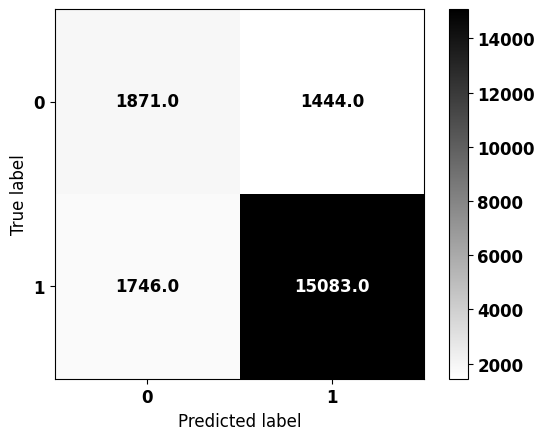


              precision    recall  f1-score   support

           0     0.5173    0.5644    0.5398      3315
           1     0.9126    0.8963    0.9044     16829

    accuracy                         0.8416     20144
   macro avg     0.7150    0.7303    0.7221     20144
weighted avg     0.8476    0.8416    0.8444     20144



In [ ]:
# Próstata
X_test_prost = prost_teste.drop(columns=list_drop).copy()
y_test_prost = prost_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_prost, y_test_prost)
plot_confusion_matrix(best, X_test_prost, y_test_prost, norm=False)

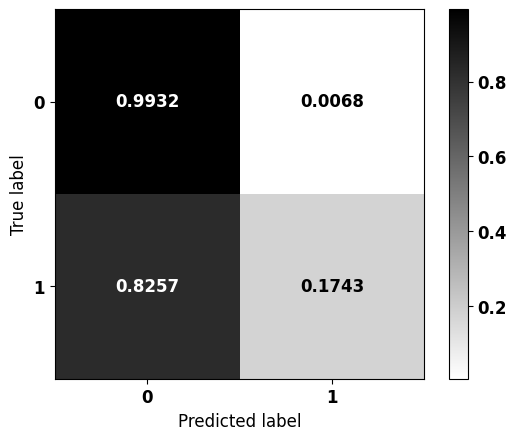


              precision    recall  f1-score   support

           0     0.8885    0.9932    0.9379      7939
           1     0.7947    0.1743    0.2859      1199

    accuracy                         0.8858      9138
   macro avg     0.8416    0.5838    0.6119      9138
weighted avg     0.8761    0.8858    0.8524      9138



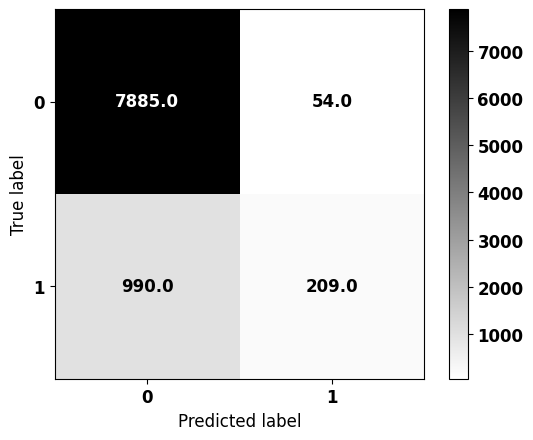


              precision    recall  f1-score   support

           0     0.8885    0.9932    0.9379      7939
           1     0.7947    0.1743    0.2859      1199

    accuracy                         0.8858      9138
   macro avg     0.8416    0.5838    0.6119      9138
weighted avg     0.8761    0.8858    0.8524      9138



In [ ]:
# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7944, Optuna = 0.7965

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7898, Optuna = 0.7939

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 2.574, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.18, max_depth=8, min_child_weight=7,
               n_estimators=145, random_state=7, verbose=-1)

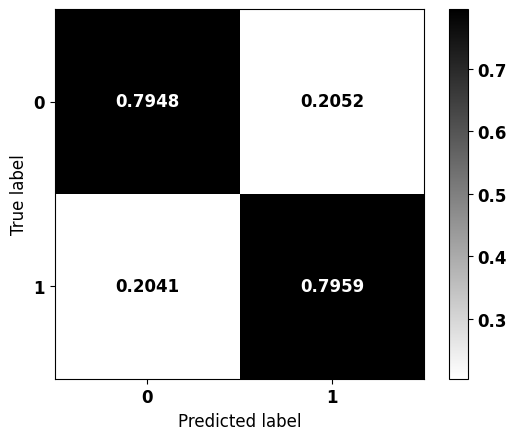


              precision    recall  f1-score   support

           0     0.6387    0.7948    0.7083     30576
           1     0.8952    0.7959    0.8426     67348

    accuracy                         0.7956     97924
   macro avg     0.7670    0.7954    0.7755     97924
weighted avg     0.8151    0.7956    0.8007     97924



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

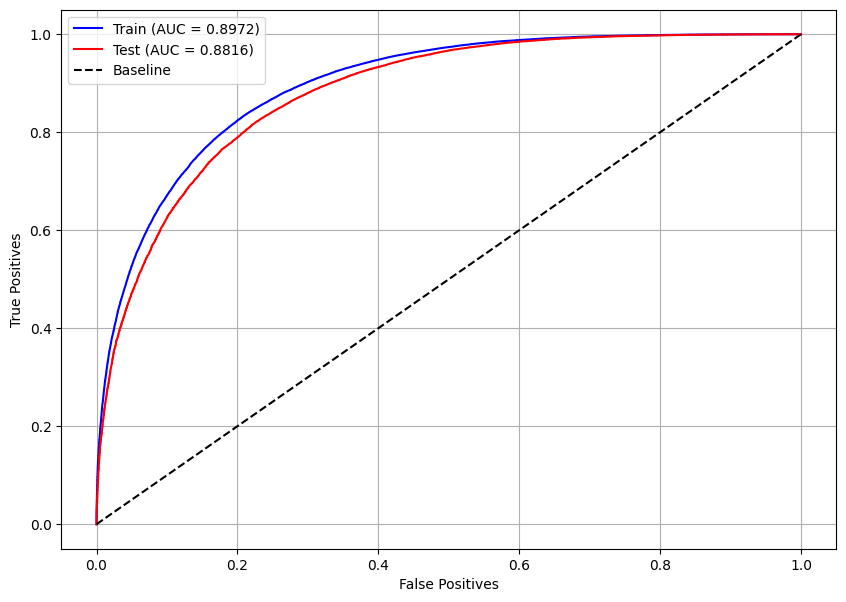

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)